In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 50.7 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
from Bio import SeqIO
from collections import Counter

# Amino acid alphabet
AminoAcids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# Mapping of amino acid characters to integers
aa_dict = {aa: i for i, aa in enumerate(AminoAcids)}

# Function to calculate Composition features
def calculate_composition(sequence):
    composition = np.zeros(20)
    for aa in sequence:
        if aa in aa_dict:
            composition[aa_dict[aa]] += 1
    total_length = len(sequence)
    if total_length > 0:
        composition = composition / total_length
    return composition

# Function to calculate Transition features
def calculate_transition(sequence):
    transition = np.zeros((20, 20))
    for i in range(1, len(sequence)):
        prev_aa = sequence[i-1]
        curr_aa = sequence[i]
        if prev_aa in aa_dict and curr_aa in aa_dict:
            transition[aa_dict[prev_aa], aa_dict[curr_aa]] += 1
    return transition.flatten()  # Flatten the transition matrix

# Function to calculate Distribution features
def calculate_distribution(sequence):
    distribution = np.zeros((20, 3))  # 3 regions: N-terminus, Middle, C-terminus
    n = len(sequence)
    if n > 0:
        for i, aa in enumerate(sequence):
            if aa in aa_dict:
                if i < n // 3:  # N-terminus
                    distribution[aa_dict[aa], 0] += 1
                elif i < 2 * n // 3:  # Middle
                    distribution[aa_dict[aa], 1] += 1
                else:  # C-terminus
                    distribution[aa_dict[aa], 2] += 1
    # Normalize the distribution by sequence length in each region
    distribution = distribution / (n / 3)
    return distribution.flatten()

# Function to extract CTDC features from sequences
def extract_ctdc_features(fasta_path):
    features = []
    for record in SeqIO.parse(fasta_path, "fasta"):
        seq = str(record.seq)
        composition = calculate_composition(seq)
        transition = calculate_transition(seq)
        distribution = calculate_distribution(seq)

        # Combine features into a single feature vector
        feature_vector = np.concatenate([composition, transition, distribution])
        features.append(feature_vector)

    # Convert the list of feature vectors into a DataFrame
    df = pd.DataFrame(features)
    return df

# Define file paths
main_p = "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/POSITIVE_main (2) (1).fasta"
main_n = "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/NEGATIVE_main (2) (1).fasta"
validation_p = "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/POSITIVE_validation (2) (1).fasta"
validation_n = "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/NEGATIVE_validation (2) (1).fasta"

# Output directories for each file
output_dirs = {
    "main_positive": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/CTDC (Physicochemical Properties)/ctdc_main_positive_features.csv",
    "main_negative": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/CTDC (Physicochemical Properties)/ctdc_main_negative_features.csv",
    "validation_positive": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/CTDC (Physicochemical Properties)/ctdc_validation_positive_features.csv",
    "validation_negative": "/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/CTDC (Physicochemical Properties)/ctdc_validation_negative_features.csv"
}

# Function to ensure the directory exists
def ensure_directory_exists(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

# Main workflow function
def main():
    # File paths for input FASTA files
    datasets = [
        (main_p, output_dirs["main_positive"]),
        (main_n, output_dirs["main_negative"]),
        (validation_p, output_dirs["validation_positive"]),
        (validation_n, output_dirs["validation_negative"])
    ]

    # Extract features and save to CSV
    for fasta_path, output_csv in datasets:
        print(f"Processing {fasta_path}...")

        # Ensure the directory for saving the output file exists
        ensure_directory_exists(output_csv)

        # Extract features and save to CSV
        features_df = extract_ctdc_features(fasta_path)
        features_df.to_csv(output_csv, index=False)
        print(f"CTDC features saved to {output_csv}")

if __name__ == "__main__":
    main()


Processing /content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/POSITIVE_main (2) (1).fasta...
CTDC features saved to /content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/CTDC (Physicochemical Properties)/ctdc_main_positive_features.csv
Processing /content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/NEGATIVE_main (2) (1).fasta...
CTDC features saved to /content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/CTDC (Physicochemical Properties)/ctdc_main_negative_features.csv
Processing /content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/POSITIVE_validation (2) (1).fasta...
CTDC features saved to /content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/CTDC (Physicochemical Properties)/ctdc_validation_positive_features.csv
Processing /content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/NEGATIVE_validation (2) (1).fasta...
CTDC features saved to /content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/CTDC (Physic

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


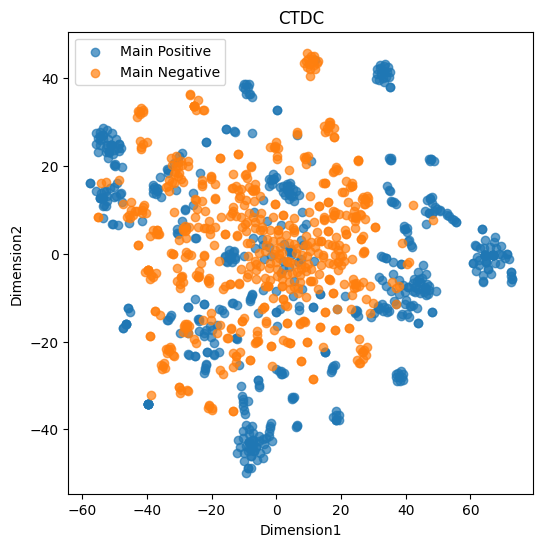

In [ ]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load AAC features for the main dataset
main_positive = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/CTDC (Physicochemical Properties)/ctdc_main_positive_features.csv")
main_negative = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/CTDC (Physicochemical Properties)/ctdc_main_negative_features.csv")

# Add labels for the main dataset
main_positive["label"] = "Main Positive"
main_negative["label"] = "Main Negative"

# Combine main datasets into one DataFrame
main_data = pd.concat([main_positive, main_negative])

# Separate features and labels
features = main_data.drop(columns=["label"])  # Drop the label column
labels = main_data["label"]  # Keep the label column

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(features)

# Add t-SNE results back to DataFrame
main_data["t-SNE-1"] = tsne_results[:, 0]
main_data["t-SNE-2"] = tsne_results[:, 1]

# Plot the t-SNE results for main dataset
plt.figure(figsize=(6, 6))
for label in main_data["label"].unique():
    subset = main_data[main_data["label"] == label]
    plt.scatter(subset["t-SNE-1"], subset["t-SNE-2"], label=label, alpha=0.7)

plt.title("CTDC")
plt.xlabel("Dimension1")
plt.ylabel("Dimension2")
plt.legend()
plt.show()


# ***All Algorithm ***

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import numpy as np

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
main_p = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/Copy of ctdc_main_positive_features.csv")
main_n = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/Copy of ctdc_main_negative_features.csv")
validation_p = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/Copy of ctdc_validation_positive_features.csv")
validation_n = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/Copy of ctdc_validation_negative_features.csv")

In [ ]:
# Label the datasets
main_p['label'] = 1
main_n['label'] = 0
validation_p['label'] = 1
validation_n['label'] = 0

# Combine datasets
train_data = pd.concat([main_p, main_n], ignore_index=True)
val_data = pd.concat([validation_p, validation_n], ignore_index=True)

# Separate features and labels
X_train = train_data.drop(columns=['label']).values
y_train = train_data['label'].values
X_val = val_data.drop(columns=['label']).values
y_val = val_data['label'].values


In [ ]:
# Dictionary of models
models = {
    "SVM": SVC(kernel='linear', probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Logistic Regression": LogisticRegression(),
    "k-NN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0),
    "AdaBoost": AdaBoostClassifier(),
    "Neural Network": Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ]),
    "MLP": Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Define Neural Network models
def create_neural_network(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_mlp(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model



In [ ]:
# Compile the neural network models
models["Neural Network"].compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
models["MLP"].compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Store accuracies
results = []

# Train each model and evaluate
for name, model in models.items():
    print(f"\nTraining {name}...")

    if name in ["Neural Network", "MLP"]:
        # Neural Network training
        model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=0)
        train_pred = (model.predict(X_train) > 0.5).astype("int32")
        val_pred = (model.predict(X_val) > 0.5).astype("int32")
    else:
        # Traditional ML model training
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)

    # Calculate train and validation accuracy
    train_accuracy = accuracy_score(y_train, train_pred)
    val_accuracy = accuracy_score(y_val, val_pred)

    results.append({"Model": name, "Train Accuracy": train_accuracy, "Validation Accuracy": val_accuracy})


Training SVM...

Training Decision Tree...

Training Random Forest...

Training Logistic Regression...

Training k-NN...

Training Naive Bayes...

Training Gradient Boosting...

Training XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:15:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Training LightGBM...
[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Training CatBoost...

Training AdaBoost...


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



Training Neural Network...
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Training MLP...
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
# Convert to DataFrame and sort by Validation Accuracy and Train Accuracy in descending order
results_df = pd.DataFrame(results).sort_values(by=["Validation Accuracy", "Train Accuracy"], ascending=False).reset_index(drop=True)

# Display results
print("\nModel Accuracy Table (Descending Order of Validation Accuracy)")
print(results_df)


Model Accuracy Table (Descending Order of Validation Accuracy)
                  Model  Train Accuracy  Validation Accuracy
0               XGBoost        0.996564             0.926667
1              LightGBM        0.996564             0.926667
2                   MLP        0.996564             0.926667
3        Neural Network        0.996564             0.923333
4              CatBoost        0.993127             0.913333
5   Logistic Regression        0.960481             0.910000
6         Random Forest        0.996564             0.903333
7                   SVM        0.977663             0.896667
8              AdaBoost        0.922680             0.896667
9     Gradient Boosting        0.975945             0.893333
10                 k-NN        0.926117             0.883333
11        Decision Tree        0.996564             0.836667
12          Naive Bayes        0.768041             0.716667


In [ ]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef, cohen_kappa_score, roc_auc_score, accuracy_score

# Store evaluation metrics
results = []

# Train each model and evaluate
for name, model in models.items():
    print(f"\nTraining {name}...")

    if name in ["Neural Network", "MLP"]:
        # Neural Network training
        model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=0)
        train_pred = (model.predict(X_train) > 0.5).astype("int32").flatten()
        val_pred = (model.predict(X_val) > 0.5).astype("int32").flatten()
    else:
        # Traditional ML model training
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)

    # Calculate metrics for validation set
    val_accuracy = accuracy_score(y_val, val_pred)
    val_cm = confusion_matrix(y_val, val_pred)
    tn, fp, fn, tp = val_cm.ravel()

    # Metrics
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall/TPR
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # TNR
    mcc = matthews_corrcoef(y_val, val_pred)
    kappa = cohen_kappa_score(y_val, val_pred)
    auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]) if name not in ["Neural Network", "MLP"] else roc_auc_score(y_val, model.predict(X_val).flatten())

    # Append results
    results.append({
        "Model": name,
        "Accuracy": val_accuracy,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "MCC": mcc,
        "Kappa": kappa,
        "AUC": auc
    })

# Convert to DataFrame and sort by AUC
results_df = pd.DataFrame(results).sort_values(by=["AUC"], ascending=False).reset_index(drop=True)

# Display results
print("\nModel Performance Metrics")
print(results_df)



Training SVM...

Training Decision Tree...

Training Random Forest...

Training Logistic Regression...

Training k-NN...

Training Naive Bayes...

Training Gradient Boosting...

Training XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:17:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Training LightGBM...
[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Training CatBoost...

Training AdaBoost...


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



Training Neural Network...
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Training MLP...
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Model Performance Metrics
                  Model  Accuracy  Sensitivity  Specificity       MCC  \
0         Random Forest  0.920000     0.933333     0.906667  0.840299   
1              LightGBM  0.926667     0.926667     0.926667  0.853333   
2               XGBoost  0.926667     0.926667     0.926667  0.853333   
3              CatBoost  0.913333     0.926667     0.900000  0.826961   
4        Neural Network  0.913333     0.893333     0.933333  0.827329   
5                   MLP  0.916667     0.900000     0.933333  0.833797   
6     Gradient Boosting  0.893333     0.913333     0.873333  0.787297   
7                  k-NN  0.883333     0.880000     0.886667  0.766684   
8   Logistic Regression  0.910000

# Cross-Validation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, matthews_corrcoef, cohen_kappa_score, roc_auc_score, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Models dictionary
models = {
    "SVM": SVC(kernel='linear', probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Logistic Regression": LogisticRegression(),
    "k-NN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0),
    "AdaBoost": AdaBoostClassifier(),
}

# Neural Network models
def create_neural_network(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_mlp(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store all results
results = []

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_probs):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Metrics calculations
    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    mcc = matthews_corrcoef(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_probs)

    return accuracy, sensitivity, specificity, mcc, kappa, auc

# Cross-validation for traditional ML models
for name, model in models.items():
    print(f"\nPerforming Cross-validation for {name}...")
    accuracies, sensitivities, specificities, mccs, kappas, aucs = [], [], [], [], [], []

    for train_index, val_index in cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Train the model
        model.fit(X_train_fold, y_train_fold)
        y_probs = model.predict_proba(X_val_fold)[:, 1]  # Probabilities for positive class
        y_pred = (y_probs > 0.5).astype(int)

        # Calculate metrics
        metrics = calculate_metrics(y_val_fold, y_pred, y_probs)
        accuracies.append(metrics[0])
        sensitivities.append(metrics[1])
        specificities.append(metrics[2])
        mccs.append(metrics[3])
        kappas.append(metrics[4])
        aucs.append(metrics[5])

    # Store mean metrics
    results.append({
        "Model": name,
        "Accuracy": np.mean(accuracies),
        "Sensitivity": np.mean(sensitivities),
        "Specificity": np.mean(specificities),
        "MCC": np.mean(mccs),
        "Kappa": np.mean(kappas),
        "AUC": np.mean(aucs),
    })

# Cross-validation for Neural Networks
for name, create_model in [("Neural Network", create_neural_network), ("MLP", create_mlp)]:
    print(f"\nPerforming Cross-validation for {name}...")
    accuracies, sensitivities, specificities, mccs, kappas, aucs = [], [], [], [], [], []

    for train_index, val_index in cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Create and train the model
        model = create_model(X_train.shape[1])
        model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0)

        y_probs = model.predict(X_val_fold).flatten()
        y_pred = (y_probs > 0.5).astype(int)

        # Calculate metrics
        metrics = calculate_metrics(y_val_fold, y_pred, y_probs)
        accuracies.append(metrics[0])
        sensitivities.append(metrics[1])
        specificities.append(metrics[2])
        mccs.append(metrics[3])
        kappas.append(metrics[4])
        aucs.append(metrics[5])

    # Store mean metrics
    results.append({
        "Model": name,
        "Accuracy": np.mean(accuracies),
        "Sensitivity": np.mean(sensitivities),
        "Specificity": np.mean(specificities),
        "MCC": np.mean(mccs),
        "Kappa": np.mean(kappas),
        "AUC": np.mean(aucs),
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results).sort_values(by="AUC", ascending=False).reset_index(drop=True)
print("\nModel Performance Metrics")
print(results_df)



Performing Cross-validation for SVM...

Performing Cross-validation for Decision Tree...

Performing Cross-validation for Random Forest...

Performing Cross-validation for Logistic Regression...

Performing Cross-validation for k-NN...

Performing Cross-validation for Naive Bayes...

Performing Cross-validation for Gradient Boosting...

Performing Cross-validation for XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:43:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:43:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:43:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:43:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:43:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


Performing Cross-validation for LightGBM...
[LightGBM] [Info] Number of positive: 465, number of negative: 466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3047
[LightGBM] [Info] Number of data points in the train set: 931, number of used features: 272
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499463 -> initscore=-0.002148
[LightGBM] [Info] Start training from score -0.002148
[LightGBM] [Info] Number of positive: 465, number of negative: 466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3062
[LightGBM] [Info] Number of data points in the train set: 931, number of us

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1


Performing Cross-validation for Neural Network...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Performing Cross-validation for MLP...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Model Performance Metrics
                  Model  Accuracy  Sensitivity  Specificity       MCC  \
0              LightGBM  0.926121     0.913999     0.938108  0.853075   
1         Random Forest  0.924390     0.912246     0.936384  0.850136   
2               XGBoost  0.926110     0.915724     0.936398  0.852936   
3              CatBoost  0.916657     0.907147     0.926068  0.834234   
4                   MLP  0.917511     0.915694     0.919231  0.835998   
5     Gradient Boosting  0.898609     0.889950     0.907206  0.797917   
6        Neural Network  0.909786     0.905393     0.914103  0.820343   
7   Logistic Regression  0.884009     0.876201     0.891689  0.769011   
8                  k-NN  0.884882     0.877984     0.891807  0.770868   
9                   SVM  0.882304     0.884836     0.879723  0.765581   
10             AdaBoost  0.869410     0.876304     0.862541  0.738941   
11        Decision Tree  0.866853     0.877984     0.855762 

# **Hyperparameter optimization with Optuna**

In [ ]:
!pip install scikeras

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import optuna
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Load datasets
main_p = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/Copy of ctdc_main_positive_features.csv")
main_n = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/Copy of ctdc_main_negative_features.csv")
validation_p = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/Copy of ctdc_validation_positive_features.csv")
validation_n = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/Copy of ctdc_validation_negative_features.csv")

# Combine positive and negative datasets
main_data = pd.concat([main_p.assign(label=1), main_n.assign(label=0)])
validation_data = pd.concat([validation_p.assign(label=1), validation_n.assign(label=0)])

# Split features and labels
X_train = main_data.drop("label", axis=1)
y_train = main_data["label"]
X_val = validation_data.drop("label", axis=1)
y_val = validation_data["label"]



# Define models with MLP included
models = {
    "SVM": lambda trial: SVC(
        C=trial.suggest_float("C", 0.1, 10.0),
        kernel=trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    ),
    "Decision Tree": lambda trial: DecisionTreeClassifier(
        max_depth=trial.suggest_int("max_depth", 3, 20),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 10)
    ),
    "Random Forest": lambda trial: RandomForestClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 500),
        max_depth=trial.suggest_int("max_depth", 3, 20),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 10)
    ),
    "Logistic Regression": lambda trial: LogisticRegression(
        C=trial.suggest_float("C", 0.1, 10.0),
        solver=trial.suggest_categorical("solver", ["lbfgs", "liblinear"])
    ),
    "k-NN": lambda trial: KNeighborsClassifier(
        n_neighbors=trial.suggest_int("n_neighbors", 3, 20)
    ),
    "Naive Bayes": lambda trial: GaussianNB(),
    "Gradient Boosting": lambda trial: GradientBoostingClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 500),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.5),
        max_depth=trial.suggest_int("max_depth", 3, 20)
    ),
    "XGBoost": lambda trial: XGBClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 500),
        max_depth=trial.suggest_int("max_depth", 3, 20),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.5),
        use_label_encoder=False,
        eval_metric="logloss"
    ),
    "LightGBM": lambda trial: LGBMClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 500),
        max_depth=trial.suggest_int("max_depth", 3, 20),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.5)
    ),
    "AdaBoost": lambda trial: AdaBoostClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 500),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 1.0)
    ),
    "Neural Network": lambda trial: MLPClassifier(
        hidden_layer_sizes=(
            trial.suggest_int("hidden_layer_1", 10, 100),
            trial.suggest_int("hidden_layer_2", 10, 100)
        ),
        learning_rate_init=trial.suggest_float("learning_rate_init", 0.001, 0.1),
        max_iter=200
    ),
    "MLP": lambda trial: MLPClassifier(
        hidden_layer_sizes=(
            trial.suggest_int("layer_1", 50, 150),
            trial.suggest_int("layer_2", 50, 150)
        ),
        activation=trial.suggest_categorical("activation", ["logistic", "tanh", "relu"]),
        solver=trial.suggest_categorical("solver", ["adam", "sgd"]),
        learning_rate_init=trial.suggest_float("learning_rate_init", 0.001, 0.1),
        max_iter=200,
        random_state=42
    )
}


results = []

def optimize_model(model_name, model_func):
    def objective(trial):
        model = model_func(trial)
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        return accuracy_score(y_val, preds)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=30)

    # Store the results
    results.append({
        "Model": model_name,
        "Accuracy": study.best_value,
        "Best Params": study.best_params
    })

# Run optimization for all models
for model_name, model_func in models.items():
    print(f"Optimizing {model_name}...")
    optimize_model(model_name, model_func)


# Convert results to a DataFrame
results_df = pd.DataFrame(results)


# Display the DataFrame
print(results_df)


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
[I 2024-12-26 17:14:44,796] A new study created in memory with name: no-name-9f7c791b-bbd7-4c92-acaa-7840f076429a


Optimizing SVM...


[I 2024-12-26 17:14:45,430] Trial 0 finished with value: 0.7266666666666667 and parameters: {'C': 5.251763791914332, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.7266666666666667.
[I 2024-12-26 17:14:46,361] Trial 1 finished with value: 0.91 and parameters: {'C': 8.938083115652116, 'kernel': 'poly'}. Best is trial 1 with value: 0.91.
[I 2024-12-26 17:14:46,979] Trial 2 finished with value: 0.9 and parameters: {'C': 3.9364149506729356, 'kernel': 'linear'}. Best is trial 1 with value: 0.91.
[I 2024-12-26 17:14:47,979] Trial 3 finished with value: 0.89 and parameters: {'C': 9.903825159000585, 'kernel': 'linear'}. Best is trial 1 with value: 0.91.
[I 2024-12-26 17:14:48,741] Trial 4 finished with value: 0.8566666666666667 and parameters: {'C': 2.453857987466257, 'kernel': 'poly'}. Best is trial 1 with value: 0.91.
[I 2024-12-26 17:14:49,218] Trial 5 finished with value: 0.8033333333333333 and parameters: {'C': 0.6943542898604925, 'kernel': 'poly'}. Best is trial 1 with value: 0.91.


Optimizing Decision Tree...


[I 2024-12-26 17:15:04,950] Trial 0 finished with value: 0.85 and parameters: {'max_depth': 11, 'min_samples_split': 6}. Best is trial 0 with value: 0.85.
[I 2024-12-26 17:15:05,057] Trial 1 finished with value: 0.81 and parameters: {'max_depth': 3, 'min_samples_split': 5}. Best is trial 0 with value: 0.85.
[I 2024-12-26 17:15:05,238] Trial 2 finished with value: 0.8466666666666667 and parameters: {'max_depth': 18, 'min_samples_split': 9}. Best is trial 0 with value: 0.85.
[I 2024-12-26 17:15:05,454] Trial 3 finished with value: 0.8466666666666667 and parameters: {'max_depth': 17, 'min_samples_split': 6}. Best is trial 0 with value: 0.85.
[I 2024-12-26 17:15:05,618] Trial 4 finished with value: 0.85 and parameters: {'max_depth': 9, 'min_samples_split': 6}. Best is trial 0 with value: 0.85.
[I 2024-12-26 17:15:05,833] Trial 5 finished with value: 0.85 and parameters: {'max_depth': 11, 'min_samples_split': 9}. Best is trial 0 with value: 0.85.
[I 2024-12-26 17:15:05,970] Trial 6 finished

Optimizing Random Forest...


[I 2024-12-26 17:15:11,406] Trial 0 finished with value: 0.9033333333333333 and parameters: {'n_estimators': 449, 'max_depth': 11, 'min_samples_split': 6}. Best is trial 0 with value: 0.9033333333333333.
[I 2024-12-26 17:15:12,688] Trial 1 finished with value: 0.8933333333333333 and parameters: {'n_estimators': 373, 'max_depth': 11, 'min_samples_split': 10}. Best is trial 0 with value: 0.9033333333333333.
[I 2024-12-26 17:15:13,502] Trial 2 finished with value: 0.9233333333333333 and parameters: {'n_estimators': 201, 'max_depth': 20, 'min_samples_split': 3}. Best is trial 2 with value: 0.9233333333333333.
[I 2024-12-26 17:15:14,358] Trial 3 finished with value: 0.9066666666666666 and parameters: {'n_estimators': 225, 'max_depth': 19, 'min_samples_split': 10}. Best is trial 2 with value: 0.9233333333333333.
[I 2024-12-26 17:15:14,981] Trial 4 finished with value: 0.8433333333333334 and parameters: {'n_estimators': 266, 'max_depth': 3, 'min_samples_split': 2}. Best is trial 2 with value:

Optimizing Logistic Regression...


[I 2024-12-26 17:15:35,975] Trial 1 finished with value: 0.91 and parameters: {'C': 2.2062025512677357, 'solver': 'liblinear'}. Best is trial 1 with value: 0.91.
[I 2024-12-26 17:15:36,165] Trial 2 finished with value: 0.9033333333333333 and parameters: {'C': 6.225652681209529, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.91.
[I 2024-12-26 17:15:36,284] Trial 3 finished with value: 0.9 and parameters: {'C': 6.850676885623416, 'solver': 'liblinear'}. Best is trial 1 with value: 0.91.
[I 2024-12-26 17:15:36,401] Trial 4 finished with value: 0.9133333333333333 and parameters: {'C': 1.41999303503696, 'solver': 'lbfgs'}. Best is trial 4 with value: 0.9133333333333333.
[I 2024-12-26 17:15:36,529] Trial 5 finished with value: 0.9 and parameters: {'C': 7.4415016586751115, 'solver': 'liblinear'}. Best is trial 4 with value: 0.9133333333333333.
[I 2024-12-26 17:15:36,706] Trial 6 finished with value: 0.9066666666666666 and parameters: {'C': 4.207283067175383, 'solver': 'lbfgs'}. Best is tri

Optimizing k-NN...


[I 2024-12-26 17:15:39,657] Trial 1 finished with value: 0.8833333333333333 and parameters: {'n_neighbors': 19}. Best is trial 0 with value: 0.8833333333333333.
[I 2024-12-26 17:15:39,726] Trial 2 finished with value: 0.8733333333333333 and parameters: {'n_neighbors': 16}. Best is trial 0 with value: 0.8833333333333333.
[I 2024-12-26 17:15:39,772] Trial 3 finished with value: 0.8833333333333333 and parameters: {'n_neighbors': 5}. Best is trial 0 with value: 0.8833333333333333.
[I 2024-12-26 17:15:39,818] Trial 4 finished with value: 0.89 and parameters: {'n_neighbors': 11}. Best is trial 4 with value: 0.89.
[I 2024-12-26 17:15:39,871] Trial 5 finished with value: 0.88 and parameters: {'n_neighbors': 18}. Best is trial 4 with value: 0.89.
[I 2024-12-26 17:15:39,917] Trial 6 finished with value: 0.8833333333333333 and parameters: {'n_neighbors': 13}. Best is trial 4 with value: 0.89.
[I 2024-12-26 17:15:39,967] Trial 7 finished with value: 0.88 and parameters: {'n_neighbors': 18}. Best i

Optimizing Naive Bayes...


[I 2024-12-26 17:15:41,415] Trial 10 finished with value: 0.7166666666666667 and parameters: {}. Best is trial 0 with value: 0.7166666666666667.
[I 2024-12-26 17:15:41,433] Trial 11 finished with value: 0.7166666666666667 and parameters: {}. Best is trial 0 with value: 0.7166666666666667.
[I 2024-12-26 17:15:41,454] Trial 12 finished with value: 0.7166666666666667 and parameters: {}. Best is trial 0 with value: 0.7166666666666667.
[I 2024-12-26 17:15:41,473] Trial 13 finished with value: 0.7166666666666667 and parameters: {}. Best is trial 0 with value: 0.7166666666666667.
[I 2024-12-26 17:15:41,492] Trial 14 finished with value: 0.7166666666666667 and parameters: {}. Best is trial 0 with value: 0.7166666666666667.
[I 2024-12-26 17:15:41,511] Trial 15 finished with value: 0.7166666666666667 and parameters: {}. Best is trial 0 with value: 0.7166666666666667.
[I 2024-12-26 17:15:41,531] Trial 16 finished with value: 0.7166666666666667 and parameters: {}. Best is trial 0 with value: 0.716

Optimizing Gradient Boosting...


[I 2024-12-26 17:15:55,759] Trial 0 finished with value: 0.92 and parameters: {'n_estimators': 313, 'learning_rate': 0.4054409705525734, 'max_depth': 8}. Best is trial 0 with value: 0.92.
[I 2024-12-26 17:16:28,815] Trial 1 finished with value: 0.9066666666666666 and parameters: {'n_estimators': 479, 'learning_rate': 0.08167126205707634, 'max_depth': 14}. Best is trial 0 with value: 0.92.
[I 2024-12-26 17:16:45,522] Trial 2 finished with value: 0.9133333333333333 and parameters: {'n_estimators': 326, 'learning_rate': 0.28898789171055067, 'max_depth': 10}. Best is trial 0 with value: 0.92.
[I 2024-12-26 17:16:58,722] Trial 3 finished with value: 0.9066666666666666 and parameters: {'n_estimators': 174, 'learning_rate': 0.45147582527921504, 'max_depth': 15}. Best is trial 0 with value: 0.92.
[I 2024-12-26 17:17:19,318] Trial 4 finished with value: 0.9 and parameters: {'n_estimators': 332, 'learning_rate': 0.3352209394210609, 'max_depth': 19}. Best is trial 0 with value: 0.92.
[I 2024-12-2

Optimizing XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:24:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-12-26 17:24:30,884] Trial 0 finished with value: 0.9133333333333333 and parameters: {'n_estimators': 440, 'max_depth': 17, 'learning_rate': 0.3456566577810634}. Best is trial 0 with value: 0.9133333333333333.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:24:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-12-26 17:24:32,096] Trial 1 finished with value: 0.9233333333333333 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.2702458538778665}. Best is trial 1 with value: 0.9233333333333333.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:24:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "us

Optimizing LightGBM...
[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

[I 2024-12-26 17:25:36,297] Trial 0 finished with value: 0.94 and parameters: {'n_estimators': 326, 'max_depth': 7, 'learning_rate': 0.3869567899427217}. Best is trial 0 with value: 0.94.


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-12-26 17:25:36,565] Trial 1 finished with value: 0.9366666666666666 and parameters: {'n_estimators': 202, 'max_depth': 14, 'learning_rate': 0.44731325019276585}. Best is trial 0 with value: 0.94.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004561 seconds.
You 

[I 2024-12-26 17:25:37,014] Trial 2 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 410, 'max_depth': 19, 'learning_rate': 0.4400453800926406}. Best is trial 0 with value: 0.94.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-12-26 17:25:37,572] Trial 3 finished with value: 0.94 and parameters: {'n_estimators': 477, 'max_depth': 12, 'learning_rate': 0.19108550457382556}. Best is trial 0 with value: 0.94.


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-12-26 17:25:37,808] Trial 4 finished with value: 0.92 and parameters: {'n_estimators': 102, 'max_depth': 16, 'learning_rate': 0.15832619584072125}. Best is trial 0 with value: 0.94.


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-12-26 17:25:38,381] Trial 5 finished with value: 0.9266666666666666 and parameters: {'n_estimators': 374, 'max_depth': 7, 'learning_rate': 0.11284789255025145}. Best is trial 0 with value: 0.94.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 17:25:38,846] Trial 6 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 466, 'max_depth': 5, 'learning_rate': 0.49026170466605795}. Best is trial 0 with value: 0.94.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 17:25:39,026] Trial 7 finished with value: 0.9266666666666666 and parameters: {'n_estimators': 89, 'max_depth': 10, 'learning_rate': 0.41164434920439835}. Best is trial 0 with value: 0.94.


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-12-26 17:25:39,279] Trial 8 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 129, 'max_depth': 8, 'learning_rate': 0.23970580689547588}. Best is trial 0 with value: 0.94.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 17:25:39,978] Trial 9 finished with value: 0.9266666666666666 and parameters: {'n_estimators': 233, 'max_depth': 16, 'learning_rate': 0.02927242987733772}. Best is trial 0 with value: 0.94.


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-12-26 17:25:40,544] Trial 10 finished with value: 0.9266666666666666 and parameters: {'n_estimators': 327, 'max_depth': 4, 'learning_rate': 0.3291079723665695}. Best is trial 0 with value: 0.94.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-12-26 17:25:41,368] Trial 11 finished with value: 0.94 and parameters: {'n_estimators': 469, 'max_depth': 11, 'learning_rate': 0.2996064860207361}. Best is trial 0 with value: 0.94.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

[I 2024-12-26 17:25:42,060] Trial 12 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 301, 'max_depth': 8, 'learning_rate': 0.21244246404005146}. Best is trial 0 with value: 0.94.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 17:25:42,801] Trial 13 finished with value: 0.9266666666666666 and parameters: {'n_estimators': 494, 'max_depth': 14, 'learning_rate': 0.34956294958243683}. Best is trial 0 with value: 0.94.


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-12-26 17:25:43,378] Trial 14 finished with value: 0.92 and parameters: {'n_estimators': 389, 'max_depth': 3, 'learning_rate': 0.16425239098713912}. Best is trial 0 with value: 0.94.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-12-26 17:25:43,872] Trial 15 finished with value: 0.9266666666666666 and parameters: {'n_estimators': 233, 'max_depth': 13, 'learning_rate': 0.36975958820282995}. Best is trial 0 with value: 0.94.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-12-26 17:25:44,547] Trial 16 finished with value: 0.93 and parameters: {'n_estimators': 336, 'max_depth': 10, 'learning_rate': 0.277293116624874}. Best is trial 0 with value: 0.94.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-12-26 17:25:45,486] Trial 17 finished with value: 0.92 and parameters: {'n_estimators': 422, 'max_depth': 6, 'learning_rate': 0.08683756492423937}. Best is trial 0 with value: 0.94.


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-12-26 17:25:45,861] Trial 18 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 159, 'max_depth': 20, 'learning_rate': 0.21022635397208606}. Best is trial 0 with value: 0.94.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 17:25:46,255] Trial 19 finished with value: 0.9433333333333334 and parameters: {'n_estimators': 278, 'max_depth': 9, 'learning_rate': 0.27050078761700874}. Best is trial 19 with value: 0.9433333333333334.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 17:25:46,625] Trial 20 finished with value: 0.93 and parameters: {'n_estimators': 268, 'max_depth': 9, 'learning_rate': 0.38414177014269674}. Best is trial 19 with value: 0.9433333333333334.


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-12-26 17:25:46,983] Trial 21 finished with value: 0.93 and parameters: {'n_estimators': 267, 'max_depth': 12, 'learning_rate': 0.296151609037223}. Best is trial 19 with value: 0.9433333333333334.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 17:25:47,514] Trial 22 finished with value: 0.9366666666666666 and parameters: {'n_estimators': 339, 'max_depth': 7, 'learning_rate': 0.16737183128426422}. Best is trial 19 with value: 0.9433333333333334.


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-12-26 17:25:47,832] Trial 23 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 185, 'max_depth': 11, 'learning_rate': 0.24316909411627163}. Best is trial 19 with value: 0.9433333333333334.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 17:25:48,008] Trial 24 finished with value: 0.9166666666666666 and parameters: {'n_estimators': 58, 'max_depth': 9, 'learning_rate': 0.12029996224265294}. Best is trial 19 with value: 0.9433333333333334.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-12-26 17:25:48,430] Trial 25 finished with value: 0.94 and parameters: {'n_estimators': 301, 'max_depth': 6, 'learning_rate': 0.3222893036716453}. Best is trial 19 with value: 0.9433333333333334.


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-12-26 17:25:48,960] Trial 26 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 447, 'max_depth': 16, 'learning_rate': 0.21003549419003534}. Best is trial 19 with value: 0.9433333333333334.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 17:25:49,444] Trial 27 finished with value: 0.9266666666666666 and parameters: {'n_estimators': 383, 'max_depth': 12, 'learning_rate': 0.26445802386051104}. Best is trial 19 with value: 0.9433333333333334.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 17:25:49,901] Trial 28 finished with value: 0.9133333333333333 and parameters: {'n_estimators': 222, 'max_depth': 9, 'learning_rate': 0.02050196167014448}. Best is trial 19 with value: 0.9433333333333334.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 17:25:50,301] Trial 29 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 354, 'max_depth': 14, 'learning_rate': 0.46707652635422503}. Best is trial 19 with value: 0.9433333333333334.
[I 2024-12-26 17:25:50,303] A new study created in memory with name: no-name-574d7e70-eb36-464b-84fc-3228f61bb7b3


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 17:25:51,894] Trial 0 finished with value: 0.87 and parameters: {'n_estimators': 187, 'learning_rate': 0.6307925448089192}. Best is trial 0 with value: 0.87.
[I 2024-12-26 17:25:52,332] Trial 1 finished with value: 0.8533333333333334 and parameters: {'n_estimators': 51, 'learning_rate': 0.38848449431918375}. Best is trial 0 with value: 0.87.
[I 2024-12-26 17:25:53,963] Trial 2 finished with value: 0.8233333333333334 and parameters: {'n_estimators': 193, 'learning_rate': 0.05189654892932803}. Best is trial 0 with value: 0.87.
[I 2024-12-26 17:25:59,389] Trial 3 finished with value: 0.87 and parameters: {'n_estimators': 492, 'learning_rate': 0.368721763150992}. Best is trial 0 with value: 0.87.
[I 2024-12-26 17:26:03,386] Trial 4 finished with value: 0.8633333333333333 and parameters: {'n_estimators': 397, 'learning_rate': 0.29748322369926916}. Best is trial 0 with value: 0.87.
[I 2024-12-26 17:26:04,381] Trial 5 finished with value: 0.8566666666666667 and parameters: {'n_e

Optimizing Neural Network...


[I 2024-12-26 17:27:29,113] Trial 0 finished with value: 0.91 and parameters: {'hidden_layer_1': 32, 'hidden_layer_2': 24, 'learning_rate_init': 0.06162394003130544}. Best is trial 0 with value: 0.91.
[I 2024-12-26 17:27:30,604] Trial 1 finished with value: 0.9133333333333333 and parameters: {'hidden_layer_1': 22, 'hidden_layer_2': 51, 'learning_rate_init': 0.06841865042565552}. Best is trial 1 with value: 0.9133333333333333.
[I 2024-12-26 17:27:32,193] Trial 2 finished with value: 0.9266666666666666 and parameters: {'hidden_layer_1': 70, 'hidden_layer_2': 24, 'learning_rate_init': 0.01997067598858698}. Best is trial 2 with value: 0.9266666666666666.
[I 2024-12-26 17:27:33,144] Trial 3 finished with value: 0.8466666666666667 and parameters: {'hidden_layer_1': 13, 'hidden_layer_2': 76, 'learning_rate_init': 0.08848217111784085}. Best is trial 2 with value: 0.9266666666666666.
[I 2024-12-26 17:27:34,462] Trial 4 finished with value: 0.9133333333333333 and parameters: {'hidden_layer_1': 5

Optimizing MLP...


[I 2024-12-26 17:28:10,031] Trial 0 finished with value: 0.9066666666666666 and parameters: {'layer_1': 106, 'layer_2': 69, 'activation': 'relu', 'solver': 'adam', 'learning_rate_init': 0.07685569770786513}. Best is trial 0 with value: 0.9066666666666666.
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2024-12-26 17:28:15,649] Trial 1 finished with value: 0.9033333333333333 and parameters: {'layer_1': 107, 'layer_2': 51, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate_init': 0.09100174721295208}. Best is trial 0 with value: 0.9066666666666666.
[I 2024-12-26 17:28:17,821] Trial 2 finished with value: 0.89 and parameters: {'layer_1': 60, 'layer_2': 105, 'activation': 'tanh', 'solver': 'adam', 'learning_rate_init': 0.017800006510984182}. Best is trial 0 with value: 0.9066666666666666.
/usr/local/li

                  Model  Accuracy  \
0                   SVM  0.923333   
1         Decision Tree  0.870000   
2         Random Forest  0.923333   
3   Logistic Regression  0.916667   
4                  k-NN  0.896667   
5           Naive Bayes  0.716667   
6     Gradient Boosting  0.926667   
7               XGBoost  0.940000   
8              LightGBM  0.943333   
9              AdaBoost  0.906667   
10       Neural Network  0.933333   
11                  MLP  0.943333   

                                          Best Params  
0          {'C': 5.9497854385624365, 'kernel': 'rbf'}  
1           {'max_depth': 19, 'min_samples_split': 3}  
2   {'n_estimators': 201, 'max_depth': 20, 'min_sa...  
3      {'C': 1.27250232990224, 'solver': 'liblinear'}  
4                                  {'n_neighbors': 8}  
5                                                  {}  
6   {'n_estimators': 407, 'learning_rate': 0.39599...  
7   {'n_estimators': 255, 'max_depth': 13, 'learni...  
8   {'n_estima

In [ ]:

from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    matthews_corrcoef,
    cohen_kappa_score,
    accuracy_score,
)


# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    mcc = matthews_corrcoef(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    return {
        "Accuracy": accuracy,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "MCC": mcc,
        "Kappa": kappa,
        "AUC": auc,
    }

# Define models with hyperparameters
models = {
    "SVM": lambda trial: SVC(
        C=trial.suggest_float("C", 0.1, 10.0),
        kernel=trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"]),
    ),
    "Decision Tree": lambda trial: DecisionTreeClassifier(
        max_depth=trial.suggest_int("max_depth", 3, 20),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
    ),
    "Random Forest": lambda trial: RandomForestClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 500),
        max_depth=trial.suggest_int("max_depth", 3, 20),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
    ),
    "Logistic Regression": lambda trial: LogisticRegression(
        C=trial.suggest_float("C", 0.1, 10.0),
        solver=trial.suggest_categorical("solver", ["lbfgs", "liblinear"]),
    ),
    "k-NN": lambda trial: KNeighborsClassifier(
        n_neighbors=trial.suggest_int("n_neighbors", 3, 20)
    ),
    "Naive Bayes": lambda trial: GaussianNB(),
    "Gradient Boosting": lambda trial: GradientBoostingClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 500),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.5),
        max_depth=trial.suggest_int("max_depth", 3, 20),
    ),
    "XGBoost": lambda trial: XGBClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 500),
        max_depth=trial.suggest_int("max_depth", 3, 20),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.5),
        use_label_encoder=False,
        eval_metric="logloss",
    ),
    "LightGBM": lambda trial: LGBMClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 500),
        max_depth=trial.suggest_int("max_depth", 3, 20),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.5),
    ),
    "AdaBoost": lambda trial: AdaBoostClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 500),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 1.0),
    ),
    "MLP": lambda trial: MLPClassifier(
        hidden_layer_sizes=(
            trial.suggest_int("layer_1", 50, 150),
            trial.suggest_int("layer_2", 50, 150),
        ),
        activation=trial.suggest_categorical("activation", ["logistic", "tanh", "relu"]),
        solver=trial.suggest_categorical("solver", ["adam", "sgd"]),
        learning_rate_init=trial.suggest_float("learning_rate_init", 0.001, 0.1),
        max_iter=200,
        random_state=42,
    ),
}

# Results storage
results = []

# Optimization function
def optimize_model_with_metrics(model_name, model_func):
    def objective(trial):
        model = model_func(trial)
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        trial.set_user_attr("preds", preds)
        metrics = calculate_metrics(y_val, preds)
        return metrics["Accuracy"]

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=30)

    # Store the best trial metrics
    best_trial_preds = study.best_trial.user_attrs["preds"]
    best_metrics = calculate_metrics(y_val, best_trial_preds)
    best_metrics["Best Params"] = study.best_params
    results.append(best_metrics)

# Run optimization for all models
for model_name, model_func in models.items():
    print(f"Optimizing {model_name}...")
    optimize_model_with_metrics(model_name, model_func)

# Store the final results with selected metrics and best parameters
final_results = []
for result in results:
    final_results.append(
        {
            "Model": result.get("Model"),
            "Accuracy": result["Accuracy"],
            "Sensitivity": result["Sensitivity"],
            "Specificity": result["Specificity"],
            "MCC": result["MCC"],
            "Kappa": result["Kappa"],
            "AUC": result["AUC"],
            "Best Params": result["Best Params"],
        }
    )

# Convert results to a DataFrame and display it
final_results_df = pd.DataFrame(final_results)
print(final_results_df)


[I 2024-12-26 17:40:03,105] A new study created in memory with name: no-name-333a67af-f394-45b6-b225-f76640139c78


Optimizing SVM...


[I 2024-12-26 17:40:03,421] Trial 0 finished with value: 0.9066666666666666 and parameters: {'C': 8.076655159277323, 'kernel': 'poly'}. Best is trial 0 with value: 0.9066666666666666.
[I 2024-12-26 17:40:03,816] Trial 1 finished with value: 0.9166666666666666 and parameters: {'C': 4.274494392870784, 'kernel': 'rbf'}. Best is trial 1 with value: 0.9166666666666666.
[I 2024-12-26 17:40:04,158] Trial 2 finished with value: 0.89 and parameters: {'C': 4.273472404118569, 'kernel': 'poly'}. Best is trial 1 with value: 0.9166666666666666.
[I 2024-12-26 17:40:04,419] Trial 3 finished with value: 0.9066666666666666 and parameters: {'C': 7.608798980352233, 'kernel': 'poly'}. Best is trial 1 with value: 0.9166666666666666.
[I 2024-12-26 17:40:04,555] Trial 4 finished with value: 0.7266666666666667 and parameters: {'C': 5.279588689018782, 'kernel': 'sigmoid'}. Best is trial 1 with value: 0.9166666666666666.
[I 2024-12-26 17:40:04,769] Trial 5 finished with value: 0.8966666666666666 and parameters: 

Optimizing Decision Tree...


[I 2024-12-26 17:40:10,363] Trial 1 finished with value: 0.8366666666666667 and parameters: {'max_depth': 7, 'min_samples_split': 5}. Best is trial 0 with value: 0.86.
[I 2024-12-26 17:40:10,471] Trial 2 finished with value: 0.85 and parameters: {'max_depth': 13, 'min_samples_split': 7}. Best is trial 0 with value: 0.86.
[I 2024-12-26 17:40:10,548] Trial 3 finished with value: 0.84 and parameters: {'max_depth': 7, 'min_samples_split': 2}. Best is trial 0 with value: 0.86.
[I 2024-12-26 17:40:10,615] Trial 4 finished with value: 0.8366666666666667 and parameters: {'max_depth': 5, 'min_samples_split': 6}. Best is trial 0 with value: 0.86.
[I 2024-12-26 17:40:10,752] Trial 5 finished with value: 0.8633333333333333 and parameters: {'max_depth': 20, 'min_samples_split': 3}. Best is trial 5 with value: 0.8633333333333333.
[I 2024-12-26 17:40:10,871] Trial 6 finished with value: 0.86 and parameters: {'max_depth': 14, 'min_samples_split': 2}. Best is trial 5 with value: 0.8633333333333333.
[I 

Optimizing Random Forest...


[I 2024-12-26 17:40:15,351] Trial 0 finished with value: 0.9066666666666666 and parameters: {'n_estimators': 191, 'max_depth': 19, 'min_samples_split': 7}. Best is trial 0 with value: 0.9066666666666666.
[I 2024-12-26 17:40:16,301] Trial 1 finished with value: 0.8933333333333333 and parameters: {'n_estimators': 228, 'max_depth': 9, 'min_samples_split': 8}. Best is trial 0 with value: 0.9066666666666666.
[I 2024-12-26 17:40:17,694] Trial 2 finished with value: 0.9033333333333333 and parameters: {'n_estimators': 375, 'max_depth': 13, 'min_samples_split': 4}. Best is trial 0 with value: 0.9066666666666666.
[I 2024-12-26 17:40:18,515] Trial 3 finished with value: 0.89 and parameters: {'n_estimators': 222, 'max_depth': 14, 'min_samples_split': 10}. Best is trial 0 with value: 0.9066666666666666.
[I 2024-12-26 17:40:20,177] Trial 4 finished with value: 0.9033333333333333 and parameters: {'n_estimators': 447, 'max_depth': 14, 'min_samples_split': 4}. Best is trial 0 with value: 0.906666666666

Optimizing Logistic Regression...


[I 2024-12-26 17:40:50,646] Trial 2 finished with value: 0.8966666666666666 and parameters: {'C': 8.711422364840894, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.9033333333333333.
[I 2024-12-26 17:40:50,736] Trial 3 finished with value: 0.8966666666666666 and parameters: {'C': 8.422560793323058, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.9033333333333333.
[I 2024-12-26 17:40:50,801] Trial 4 finished with value: 0.9 and parameters: {'C': 7.762752179184839, 'solver': 'liblinear'}. Best is trial 1 with value: 0.9033333333333333.
[I 2024-12-26 17:40:50,857] Trial 5 finished with value: 0.91 and parameters: {'C': 2.312593166257206, 'solver': 'liblinear'}. Best is trial 5 with value: 0.91.
[I 2024-12-26 17:40:50,951] Trial 6 finished with value: 0.9 and parameters: {'C': 9.57284862353185, 'solver': 'lbfgs'}. Best is trial 5 with value: 0.91.
[I 2024-12-26 17:40:51,030] Trial 7 finished with value: 0.9033333333333333 and parameters: {'C': 6.456248175277949, 'solver': 'lbfgs'}. Bes

Optimizing k-NN...


[I 2024-12-26 17:40:52,818] Trial 3 finished with value: 0.88 and parameters: {'n_neighbors': 18}. Best is trial 2 with value: 0.89.
[I 2024-12-26 17:40:52,874] Trial 4 finished with value: 0.87 and parameters: {'n_neighbors': 15}. Best is trial 2 with value: 0.89.
[I 2024-12-26 17:40:52,925] Trial 5 finished with value: 0.8833333333333333 and parameters: {'n_neighbors': 10}. Best is trial 2 with value: 0.89.
[I 2024-12-26 17:40:52,978] Trial 6 finished with value: 0.8766666666666667 and parameters: {'n_neighbors': 17}. Best is trial 2 with value: 0.89.
[I 2024-12-26 17:40:53,031] Trial 7 finished with value: 0.89 and parameters: {'n_neighbors': 4}. Best is trial 2 with value: 0.89.
[I 2024-12-26 17:40:53,081] Trial 8 finished with value: 0.8966666666666666 and parameters: {'n_neighbors': 8}. Best is trial 8 with value: 0.8966666666666666.
[I 2024-12-26 17:40:53,147] Trial 9 finished with value: 0.8966666666666666 and parameters: {'n_neighbors': 8}. Best is trial 8 with value: 0.896666

Optimizing Naive Bayes...


[I 2024-12-26 17:40:54,553] Trial 7 finished with value: 0.7166666666666667 and parameters: {}. Best is trial 0 with value: 0.7166666666666667.
[I 2024-12-26 17:40:54,581] Trial 8 finished with value: 0.7166666666666667 and parameters: {}. Best is trial 0 with value: 0.7166666666666667.
[I 2024-12-26 17:40:54,606] Trial 9 finished with value: 0.7166666666666667 and parameters: {}. Best is trial 0 with value: 0.7166666666666667.
[I 2024-12-26 17:40:54,642] Trial 10 finished with value: 0.7166666666666667 and parameters: {}. Best is trial 0 with value: 0.7166666666666667.
[I 2024-12-26 17:40:54,666] Trial 11 finished with value: 0.7166666666666667 and parameters: {}. Best is trial 0 with value: 0.7166666666666667.
[I 2024-12-26 17:40:54,691] Trial 12 finished with value: 0.7166666666666667 and parameters: {}. Best is trial 0 with value: 0.7166666666666667.
[I 2024-12-26 17:40:54,715] Trial 13 finished with value: 0.7166666666666667 and parameters: {}. Best is trial 0 with value: 0.716666

Optimizing Gradient Boosting...


[I 2024-12-26 17:40:59,896] Trial 0 finished with value: 0.9066666666666666 and parameters: {'n_estimators': 252, 'learning_rate': 0.2338861098484771, 'max_depth': 3}. Best is trial 0 with value: 0.9066666666666666.
[I 2024-12-26 17:41:22,297] Trial 1 finished with value: 0.91 and parameters: {'n_estimators': 477, 'learning_rate': 0.01967675393811148, 'max_depth': 8}. Best is trial 1 with value: 0.91.
[I 2024-12-26 17:41:47,809] Trial 2 finished with value: 0.9166666666666666 and parameters: {'n_estimators': 448, 'learning_rate': 0.22125181934258265, 'max_depth': 12}. Best is trial 2 with value: 0.9166666666666666.
[I 2024-12-26 17:41:58,244] Trial 3 finished with value: 0.9166666666666666 and parameters: {'n_estimators': 171, 'learning_rate': 0.3705819125144201, 'max_depth': 14}. Best is trial 2 with value: 0.9166666666666666.
[I 2024-12-26 17:42:15,606] Trial 4 finished with value: 0.9166666666666666 and parameters: {'n_estimators': 339, 'learning_rate': 0.4556198075496579, 'max_dept

Optimizing XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:47:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-12-26 17:47:35,010] Trial 0 finished with value: 0.9266666666666666 and parameters: {'n_estimators': 288, 'max_depth': 20, 'learning_rate': 0.13904001811287456}. Best is trial 0 with value: 0.9266666666666666.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:47:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-12-26 17:47:36,609] Trial 1 finished with value: 0.9266666666666666 and parameters: {'n_estimators': 258, 'max_depth': 6, 'learning_rate': 0.08701759066677454}. Best is trial 0 with value: 0.9266666666666666.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:47:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "

Optimizing LightGBM...
[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

[I 2024-12-26 17:48:47,971] Trial 0 finished with value: 0.9466666666666667 and parameters: {'n_estimators': 445, 'max_depth': 5, 'learning_rate': 0.409477385393522}. Best is trial 0 with value: 0.9466666666666667.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-12-26 17:48:48,283] Trial 1 finished with value: 0.9466666666666667 and parameters: {'n_estimators': 97, 'max_depth': 19, 'learning_rate': 0.4673032825969378}. Best is trial 0 with value: 0.9466666666666667.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 17:48:48,626] Trial 2 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 114, 'max_depth': 12, 'learning_rate': 0.38091889235650284}. Best is trial 0 with value: 0.9466666666666667.


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-12-26 17:48:49,383] Trial 3 finished with value: 0.92 and parameters: {'n_estimators': 237, 'max_depth': 16, 'learning_rate': 0.05199610250409694}. Best is trial 0 with value: 0.9466666666666667.


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-12-26 17:48:50,030] Trial 4 finished with value: 0.9133333333333333 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.09815103172398405}. Best is trial 0 with value: 0.9466666666666667.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 17:48:50,382] Trial 5 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 309, 'max_depth': 18, 'learning_rate': 0.41889654601559784}. Best is trial 0 with value: 0.9466666666666667.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 17:48:50,839] Trial 6 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 383, 'max_depth': 7, 'learning_rate': 0.2982760450819414}. Best is trial 0 with value: 0.9466666666666667.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 17:48:51,150] Trial 7 finished with value: 0.94 and parameters: {'n_estimators': 229, 'max_depth': 11, 'learning_rate': 0.38982517494446506}. Best is trial 0 with value: 0.9466666666666667.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-12-26 17:48:51,665] Trial 8 finished with value: 0.94 and parameters: {'n_estimators': 462, 'max_depth': 12, 'learning_rate': 0.2690934552199688}. Best is trial 0 with value: 0.9466666666666667.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 17:48:52,003] Trial 9 finished with value: 0.9266666666666666 and parameters: {'n_estimators': 168, 'max_depth': 20, 'learning_rate': 0.12407082001696164}. Best is trial 0 with value: 0.9466666666666667.


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-12-26 17:48:52,506] Trial 10 finished with value: 0.9266666666666666 and parameters: {'n_estimators': 497, 'max_depth': 3, 'learning_rate': 0.18506894692280454}. Best is trial 0 with value: 0.9466666666666667.
[I 2024-12-26 17:48:52,698] Trial 11 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 86, 'max_depth': 15, 'learning_rate': 0.48584604937771647}. Best is trial 0 with value: 0.9466666666666667.


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-12-26 17:48:53,138] Trial 12 finished with value: 0.94 and parameters: {'n_estimators': 389, 'max_depth': 8, 'learning_rate': 0.48685184033251}. Best is trial 0 with value: 0.9466666666666667.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 17:48:53,268] Trial 13 finished with value: 0.9166666666666666 and parameters: {'n_estimators': 59, 'max_depth': 3, 'learning_rate': 0.3480422543483228}. Best is trial 0 with value: 0.9466666666666667.


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-12-26 17:48:53,536] Trial 14 finished with value: 0.93 and parameters: {'n_estimators': 155, 'max_depth': 10, 'learning_rate': 0.4398683053709183}. Best is trial 0 with value: 0.9466666666666667.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 17:48:53,988] Trial 15 finished with value: 0.9366666666666666 and parameters: {'n_estimators': 382, 'max_depth': 15, 'learning_rate': 0.32348263713109293}. Best is trial 0 with value: 0.9466666666666667.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 17:48:54,279] Trial 16 finished with value: 0.9266666666666666 and parameters: {'n_estimators': 200, 'max_depth': 19, 'learning_rate': 0.4932000059968877}. Best is trial 0 with value: 0.9466666666666667.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-12-26 17:48:54,816] Trial 17 finished with value: 0.9366666666666666 and parameters: {'n_estimators': 433, 'max_depth': 5, 'learning_rate': 0.21059702226617705}. Best is trial 0 with value: 0.9466666666666667.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 17:48:55,193] Trial 18 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 274, 'max_depth': 9, 'learning_rate': 0.44040752288726054}. Best is trial 0 with value: 0.9466666666666667.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 17:48:55,635] Trial 19 finished with value: 0.9266666666666666 and parameters: {'n_estimators': 351, 'max_depth': 14, 'learning_rate': 0.34920220865728935}. Best is trial 0 with value: 0.9466666666666667.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 17:48:55,905] Trial 20 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 127, 'max_depth': 17, 'learning_rate': 0.23696922918274146}. Best is trial 0 with value: 0.9466666666666667.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 17:48:56,222] Trial 21 finished with value: 0.94 and parameters: {'n_estimators': 226, 'max_depth': 11, 'learning_rate': 0.3975246271898343}. Best is trial 0 with value: 0.9466666666666667.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 17:48:56,501] Trial 22 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 184, 'max_depth': 14, 'learning_rate': 0.4476281729732655}. Best is trial 0 with value: 0.9466666666666667.


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-12-26 17:48:56,848] Trial 23 finished with value: 0.9433333333333334 and parameters: {'n_estimators': 258, 'max_depth': 13, 'learning_rate': 0.37827630289397207}. Best is trial 0 with value: 0.9466666666666667.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 17:48:57,269] Trial 24 finished with value: 0.9366666666666666 and parameters: {'n_estimators': 337, 'max_depth': 13, 'learning_rate': 0.3549124260580934}. Best is trial 0 with value: 0.9466666666666667.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-12-26 17:48:57,779] Trial 25 finished with value: 0.93 and parameters: {'n_estimators': 430, 'max_depth': 5, 'learning_rate': 0.2841562978477141}. Best is trial 0 with value: 0.9466666666666667.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 17:48:58,118] Trial 26 finished with value: 0.93 and parameters: {'n_estimators': 264, 'max_depth': 20, 'learning_rate': 0.4587391870032195}. Best is trial 0 with value: 0.9466666666666667.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 17:48:58,374] Trial 27 finished with value: 0.9366666666666666 and parameters: {'n_estimators': 136, 'max_depth': 17, 'learning_rate': 0.4150512236497445}. Best is trial 0 with value: 0.9466666666666667.


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-12-26 17:48:58,555] Trial 28 finished with value: 0.92 and parameters: {'n_estimators': 60, 'max_depth': 9, 'learning_rate': 0.3149450056974712}. Best is trial 0 with value: 0.9466666666666667.


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-12-26 17:48:58,783] Trial 29 finished with value: 0.92 and parameters: {'n_estimators': 92, 'max_depth': 13, 'learning_rate': 0.38877457013128375}. Best is trial 0 with value: 0.9466666666666667.
[I 2024-12-26 17:48:58,799] A new study created in memory with name: no-name-a631f33b-fdeb-4cce-ae7c-cfbf51c5bd89


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 17:49:01,858] Trial 0 finished with value: 0.9 and parameters: {'n_estimators': 283, 'learning_rate': 0.905749614225417}. Best is trial 0 with value: 0.9.
[I 2024-12-26 17:49:06,324] Trial 1 finished with value: 0.88 and parameters: {'n_estimators': 398, 'learning_rate': 0.5580111726447452}. Best is trial 0 with value: 0.9.
[I 2024-12-26 17:49:06,892] Trial 2 finished with value: 0.8566666666666667 and parameters: {'n_estimators': 66, 'learning_rate': 0.5225058174932685}. Best is trial 0 with value: 0.9.
[I 2024-12-26 17:49:07,430] Trial 3 finished with value: 0.86 and parameters: {'n_estimators': 61, 'learning_rate': 0.6096455676506407}. Best is trial 0 with value: 0.9.
[I 2024-12-26 17:49:10,553] Trial 4 finished with value: 0.88 and parameters: {'n_estimators': 378, 'learning_rate': 0.4325901181667917}. Best is trial 0 with value: 0.9.
[I 2024-12-26 17:49:12,650] Trial 5 finished with value: 0.8966666666666666 and parameters: {'n_estimators': 252, 'learning_rate': 0.84

Optimizing MLP...


[I 2024-12-26 17:50:23,072] Trial 0 finished with value: 0.92 and parameters: {'layer_1': 79, 'layer_2': 101, 'activation': 'tanh', 'solver': 'adam', 'learning_rate_init': 0.07078383279702012}. Best is trial 0 with value: 0.92.
[I 2024-12-26 17:50:27,458] Trial 1 finished with value: 0.9133333333333333 and parameters: {'layer_1': 61, 'layer_2': 55, 'activation': 'tanh', 'solver': 'sgd', 'learning_rate_init': 0.0348821755326398}. Best is trial 0 with value: 0.92.
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2024-12-26 17:50:35,536] Trial 2 finished with value: 0.91 and parameters: {'layer_1': 135, 'layer_2': 75, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate_init': 0.05729657815759911}. Best is trial 0 with value: 0.92.
[I 2024-12-26 17:50:40,675] Trial 3 finished with value: 0.94333333333333

   Model  Accuracy  Sensitivity  Specificity       MCC     Kappa       AUC  \
0   None  0.923333     0.906667     0.940000  0.847137  0.846667  0.923333   
1   None  0.870000     0.860000     0.880000  0.740148  0.740000  0.870000   
2   None  0.930000     0.933333     0.926667  0.860019  0.860000  0.930000   
3   None  0.916667     0.920000     0.913333  0.833352  0.833333  0.916667   
4   None  0.896667     0.860000     0.933333  0.795475  0.793333  0.896667   
5   None  0.716667     0.940000     0.493333  0.484333  0.433333  0.716667   
6   None  0.923333     0.926667     0.920000  0.846685  0.846667  0.923333   
7   None  0.936667     0.946667     0.926667  0.873508  0.873333  0.936667   
8   None  0.946667     0.953333     0.940000  0.893413  0.893333  0.946667   
9   None  0.900000     0.900000     0.900000  0.800000  0.800000  0.900000   
10  None  0.943333     0.940000     0.946667  0.886686  0.886667  0.943333   

                                          Best Params  
0      

In [ ]:
import pandas as pd
import optuna
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Define models
models = {
    "SVM": lambda trial: SVC(probability=True, C=trial.suggest_float("C", 0.1, 10.0), kernel=trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])),
    "Decision Tree": lambda trial: DecisionTreeClassifier(max_depth=trial.suggest_int("max_depth", 3, 20), min_samples_split=trial.suggest_int("min_samples_split", 2, 10)),
    "Random Forest": lambda trial: RandomForestClassifier(n_estimators=trial.suggest_int("n_estimators", 50, 500), max_depth=trial.suggest_int("max_depth", 3, 20), min_samples_split=trial.suggest_int("min_samples_split", 2, 10)),
    "Logistic Regression": lambda trial: LogisticRegression(C=trial.suggest_float("C", 0.1, 10.0), solver=trial.suggest_categorical("solver", ["lbfgs", "liblinear"])),
    "k-NN": lambda trial: KNeighborsClassifier(n_neighbors=trial.suggest_int("n_neighbors", 3, 20)),
    "Naive Bayes": lambda trial: GaussianNB(),
    "Gradient Boosting": lambda trial: GradientBoostingClassifier(n_estimators=trial.suggest_int("n_estimators", 50, 500), learning_rate=trial.suggest_float("learning_rate", 0.01, 0.5), max_depth=trial.suggest_int("max_depth", 3, 20)),
    "XGBoost": lambda trial: XGBClassifier(n_estimators=trial.suggest_int("n_estimators", 50, 500), max_depth=trial.suggest_int("max_depth", 3, 20), learning_rate=trial.suggest_float("learning_rate", 0.01, 0.5), use_label_encoder=False, eval_metric="logloss"),
    "LightGBM": lambda trial: LGBMClassifier(n_estimators=trial.suggest_int("n_estimators", 50, 500), max_depth=trial.suggest_int("max_depth", 3, 20), learning_rate=trial.suggest_float("learning_rate", 0.01, 0.5)),
    "AdaBoost": lambda trial: AdaBoostClassifier(n_estimators=trial.suggest_int("n_estimators", 50, 500), learning_rate=trial.suggest_float("learning_rate", 0.01, 1.0)),
    "Neural Network": lambda trial: MLPClassifier(hidden_layer_sizes=(trial.suggest_int("hidden_layer_1", 10, 100), trial.suggest_int("hidden_layer_2", 10, 100)), learning_rate_init=trial.suggest_float("learning_rate_init", 0.001, 0.1), max_iter=200),
    "MLP": lambda trial: MLPClassifier(hidden_layer_sizes=(trial.suggest_int("layer_1", 50, 150), trial.suggest_int("layer_2", 50, 150)), activation=trial.suggest_categorical("activation", ["logistic", "tanh", "relu"]), solver=trial.suggest_categorical("solver", ["adam", "sgd"]), learning_rate_init=trial.suggest_float("learning_rate_init", 0.001, 0.1), max_iter=200, random_state=42)
}

# Prepare a dictionary to store model probabilities horizontally
probabilities = {"Target": y_val}  # Starting with the target column (y_val)

# Run optimization and compute probabilities for each model
for model_name, model_func in models.items():
    print(f"Optimizing {model_name}...")
    study = optuna.create_study(direction="maximize")

    # Objective function for Optuna
    def objective(trial):
        model = model_func(trial)
        model.fit(X_train, y_train)
        return accuracy_score(y_val, model.predict(X_val))

    study.optimize(objective, n_trials=30)

    # Train the best model using the best hyperparameters
    best_model = model_func(study.best_trial)
    best_model.fit(X_train, y_train)

    # Get predicted probabilities for the positive class (class 1)
    probs = best_model.predict_proba(X_val)[:, 1]

    # Add to the probabilities dictionary
    probabilities[model_name] = probs

# Convert the probabilities dictionary to a DataFrame
probability_df = pd.DataFrame(probabilities)

# Save the probability dataset to a CSV file
probability_df.to_csv("N_CTDC_OPTUNA_probability_predictions.csv", index=False)

print("Dataset saved successfully!")


[I 2024-12-26 17:52:53,371] A new study created in memory with name: no-name-b595d6c3-2669-4283-afbd-648d42468fad


Optimizing SVM...


[I 2024-12-26 17:52:54,213] Trial 0 finished with value: 0.8866666666666667 and parameters: {'C': 2.265680780523493, 'kernel': 'linear'}. Best is trial 0 with value: 0.8866666666666667.
[I 2024-12-26 17:52:54,759] Trial 1 finished with value: 0.72 and parameters: {'C': 9.447520232953032, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.8866666666666667.
[I 2024-12-26 17:52:55,892] Trial 2 finished with value: 0.92 and parameters: {'C': 5.466217434089017, 'kernel': 'rbf'}. Best is trial 2 with value: 0.92.
[I 2024-12-26 17:52:56,413] Trial 3 finished with value: 0.72 and parameters: {'C': 6.715646654070279, 'kernel': 'sigmoid'}. Best is trial 2 with value: 0.92.
[I 2024-12-26 17:52:57,430] Trial 4 finished with value: 0.9033333333333333 and parameters: {'C': 6.059924086081524, 'kernel': 'poly'}. Best is trial 2 with value: 0.92.
[I 2024-12-26 17:52:58,712] Trial 5 finished with value: 0.9033333333333333 and parameters: {'C': 6.642571532401059, 'kernel': 'poly'}. Best is trial 2 with 

Optimizing Decision Tree...


[I 2024-12-26 17:53:27,170] Trial 4 finished with value: 0.8633333333333333 and parameters: {'max_depth': 12, 'min_samples_split': 4}. Best is trial 4 with value: 0.8633333333333333.
[I 2024-12-26 17:53:27,201] Trial 5 finished with value: 0.83 and parameters: {'max_depth': 4, 'min_samples_split': 4}. Best is trial 4 with value: 0.8633333333333333.
[I 2024-12-26 17:53:27,250] Trial 6 finished with value: 0.8233333333333334 and parameters: {'max_depth': 5, 'min_samples_split': 4}. Best is trial 4 with value: 0.8633333333333333.
[I 2024-12-26 17:53:27,329] Trial 7 finished with value: 0.86 and parameters: {'max_depth': 20, 'min_samples_split': 6}. Best is trial 4 with value: 0.8633333333333333.
[I 2024-12-26 17:53:27,373] Trial 8 finished with value: 0.8333333333333334 and parameters: {'max_depth': 6, 'min_samples_split': 10}. Best is trial 4 with value: 0.8633333333333333.
[I 2024-12-26 17:53:27,442] Trial 9 finished with value: 0.8466666666666667 and parameters: {'max_depth': 14, 'min_

Optimizing Random Forest...


[I 2024-12-26 17:53:31,531] Trial 0 finished with value: 0.8966666666666666 and parameters: {'n_estimators': 387, 'max_depth': 14, 'min_samples_split': 8}. Best is trial 0 with value: 0.8966666666666666.
[I 2024-12-26 17:53:32,894] Trial 1 finished with value: 0.8866666666666667 and parameters: {'n_estimators': 277, 'max_depth': 8, 'min_samples_split': 10}. Best is trial 0 with value: 0.8966666666666666.
[I 2024-12-26 17:53:33,562] Trial 2 finished with value: 0.9066666666666666 and parameters: {'n_estimators': 106, 'max_depth': 17, 'min_samples_split': 7}. Best is trial 2 with value: 0.9066666666666666.
[I 2024-12-26 17:53:35,614] Trial 3 finished with value: 0.9033333333333333 and parameters: {'n_estimators': 432, 'max_depth': 15, 'min_samples_split': 9}. Best is trial 2 with value: 0.9066666666666666.
[I 2024-12-26 17:53:37,159] Trial 4 finished with value: 0.8966666666666666 and parameters: {'n_estimators': 460, 'max_depth': 10, 'min_samples_split': 4}. Best is trial 2 with value: 

Optimizing Logistic Regression...


[I 2024-12-26 17:54:07,235] Trial 3 finished with value: 0.9 and parameters: {'C': 6.797767232978044, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.91.
[I 2024-12-26 17:54:07,319] Trial 4 finished with value: 0.9 and parameters: {'C': 7.81538470923986, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.91.
[I 2024-12-26 17:54:07,367] Trial 5 finished with value: 0.91 and parameters: {'C': 2.140998783078759, 'solver': 'liblinear'}. Best is trial 0 with value: 0.91.
[I 2024-12-26 17:54:07,445] Trial 6 finished with value: 0.9033333333333333 and parameters: {'C': 4.752862472583457, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.91.
[I 2024-12-26 17:54:07,528] Trial 7 finished with value: 0.9033333333333333 and parameters: {'C': 5.3038070439420935, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.91.
[I 2024-12-26 17:54:07,609] Trial 8 finished with value: 0.9 and parameters: {'C': 8.724942438845043, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.91.
[I 2024-12-26 17:54:07,663] T

Optimizing k-NN...


[I 2024-12-26 17:54:09,159] Trial 3 finished with value: 0.8833333333333333 and parameters: {'n_neighbors': 10}. Best is trial 0 with value: 0.8866666666666667.
[I 2024-12-26 17:54:09,220] Trial 4 finished with value: 0.87 and parameters: {'n_neighbors': 15}. Best is trial 0 with value: 0.8866666666666667.
[I 2024-12-26 17:54:09,266] Trial 5 finished with value: 0.8966666666666666 and parameters: {'n_neighbors': 3}. Best is trial 5 with value: 0.8966666666666666.
[I 2024-12-26 17:54:09,311] Trial 6 finished with value: 0.8866666666666667 and parameters: {'n_neighbors': 20}. Best is trial 5 with value: 0.8966666666666666.
[I 2024-12-26 17:54:09,358] Trial 7 finished with value: 0.8833333333333333 and parameters: {'n_neighbors': 5}. Best is trial 5 with value: 0.8966666666666666.
[I 2024-12-26 17:54:09,411] Trial 8 finished with value: 0.8766666666666667 and parameters: {'n_neighbors': 9}. Best is trial 5 with value: 0.8966666666666666.
[I 2024-12-26 17:54:09,456] Trial 9 finished with v

Optimizing Naive Bayes...


[I 2024-12-26 17:54:10,771] Trial 10 finished with value: 0.7166666666666667 and parameters: {}. Best is trial 0 with value: 0.7166666666666667.
[I 2024-12-26 17:54:10,789] Trial 11 finished with value: 0.7166666666666667 and parameters: {}. Best is trial 0 with value: 0.7166666666666667.
[I 2024-12-26 17:54:10,810] Trial 12 finished with value: 0.7166666666666667 and parameters: {}. Best is trial 0 with value: 0.7166666666666667.
[I 2024-12-26 17:54:10,828] Trial 13 finished with value: 0.7166666666666667 and parameters: {}. Best is trial 0 with value: 0.7166666666666667.
[I 2024-12-26 17:54:10,846] Trial 14 finished with value: 0.7166666666666667 and parameters: {}. Best is trial 0 with value: 0.7166666666666667.
[I 2024-12-26 17:54:10,864] Trial 15 finished with value: 0.7166666666666667 and parameters: {}. Best is trial 0 with value: 0.7166666666666667.
[I 2024-12-26 17:54:10,886] Trial 16 finished with value: 0.7166666666666667 and parameters: {}. Best is trial 0 with value: 0.716

Optimizing Gradient Boosting...


[I 2024-12-26 17:54:17,581] Trial 0 finished with value: 0.9133333333333333 and parameters: {'n_estimators': 299, 'learning_rate': 0.4460643697356496, 'max_depth': 4}. Best is trial 0 with value: 0.9133333333333333.
[I 2024-12-26 17:54:35,636] Trial 1 finished with value: 0.91 and parameters: {'n_estimators': 396, 'learning_rate': 0.27418218646861, 'max_depth': 8}. Best is trial 0 with value: 0.9133333333333333.
[I 2024-12-26 17:55:09,240] Trial 2 finished with value: 0.9133333333333333 and parameters: {'n_estimators': 487, 'learning_rate': 0.08672429873193144, 'max_depth': 15}. Best is trial 0 with value: 0.9133333333333333.
[I 2024-12-26 17:55:15,439] Trial 3 finished with value: 0.9033333333333333 and parameters: {'n_estimators': 98, 'learning_rate': 0.4710639276280299, 'max_depth': 18}. Best is trial 0 with value: 0.9133333333333333.
[I 2024-12-26 17:55:41,962] Trial 4 finished with value: 0.9133333333333333 and parameters: {'n_estimators': 426, 'learning_rate': 0.1737351401967663,

Optimizing XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:03:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-12-26 18:03:04,390] Trial 0 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 356, 'max_depth': 5, 'learning_rate': 0.4359315554432092}. Best is trial 0 with value: 0.9333333333333333.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:03:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-12-26 18:03:06,528] Trial 1 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 484, 'max_depth': 4, 'learning_rate': 0.15508876316777978}. Best is trial 0 with value: 0.9333333333333333.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:03:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "us

Optimizing LightGBM...
[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

[I 2024-12-26 18:04:06,598] Trial 0 finished with value: 0.93 and parameters: {'n_estimators': 174, 'max_depth': 13, 'learning_rate': 0.10408541193427115}. Best is trial 0 with value: 0.93.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.50000

[I 2024-12-26 18:04:06,749] Trial 1 finished with value: 0.92 and parameters: {'n_estimators': 56, 'max_depth': 12, 'learning_rate': 0.24051033114750192}. Best is trial 0 with value: 0.93.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

[I 2024-12-26 18:04:07,111] Trial 2 finished with value: 0.93 and parameters: {'n_estimators': 332, 'max_depth': 6, 'learning_rate': 0.4392380579401717}. Best is trial 0 with value: 0.93.


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-12-26 18:04:07,537] Trial 3 finished with value: 0.9366666666666666 and parameters: {'n_estimators': 368, 'max_depth': 20, 'learning_rate': 0.24193701965054915}. Best is trial 3 with value: 0.9366666666666666.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 18:04:07,938] Trial 4 finished with value: 0.9433333333333334 and parameters: {'n_estimators': 375, 'max_depth': 19, 'learning_rate': 0.33446681235994097}. Best is trial 4 with value: 0.9433333333333334.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 18:04:08,170] Trial 5 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 152, 'max_depth': 9, 'learning_rate': 0.4652629719431719}. Best is trial 4 with value: 0.9433333333333334.


[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[I 2024-12-26 18:04:08,845] Trial 6 finished with value: 0.9166666666666666 and parameters: {'n_estimators': 340, 'max_depth': 13, 'learning_rate': 0.04689721532991605}. Best is trial 4 with value: 0.9433333333333334.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 18:04:09,226] Trial 7 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 332, 'max_depth': 7, 'learning_rate': 0.3332143367347256}. Best is trial 4 with value: 0.9433333333333334.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 18:04:09,562] Trial 8 finished with value: 0.9266666666666666 and parameters: {'n_estimators': 302, 'max_depth': 15, 'learning_rate': 0.45938652648581413}. Best is trial 4 with value: 0.9433333333333334.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 18:04:10,000] Trial 9 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 442, 'max_depth': 9, 'learning_rate': 0.4077365239633134}. Best is trial 4 with value: 0.9433333333333334.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 18:04:10,820] Trial 10 finished with value: 0.93 and parameters: {'n_estimators': 494, 'max_depth': 20, 'learning_rate': 0.1632262800585469}. Best is trial 4 with value: 0.9433333333333334.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-12-26 18:04:11,565] Trial 11 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 421, 'max_depth': 20, 'learning_rate': 0.2813022978182645}. Best is trial 4 with value: 0.9433333333333334.


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-12-26 18:04:12,304] Trial 12 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 398, 'max_depth': 17, 'learning_rate': 0.20512413813057423}. Best is trial 4 with value: 0.9433333333333334.


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-12-26 18:04:12,672] Trial 13 finished with value: 0.9166666666666666 and parameters: {'n_estimators': 203, 'max_depth': 3, 'learning_rate': 0.35405316044592383}. Best is trial 4 with value: 0.9433333333333334.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-12-26 18:04:13,188] Trial 14 finished with value: 0.9266666666666666 and parameters: {'n_estimators': 249, 'max_depth': 17, 'learning_rate': 0.3186059977094141}. Best is trial 4 with value: 0.9433333333333334.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

[I 2024-12-26 18:04:13,972] Trial 15 finished with value: 0.9433333333333334 and parameters: {'n_estimators': 395, 'max_depth': 18, 'learning_rate': 0.16617413474660775}. Best is trial 4 with value: 0.9433333333333334.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 18:04:14,916] Trial 16 finished with value: 0.94 and parameters: {'n_estimators': 482, 'max_depth': 17, 'learning_rate': 0.14552283599910482}. Best is trial 4 with value: 0.9433333333333334.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

[I 2024-12-26 18:04:15,796] Trial 17 finished with value: 0.92 and parameters: {'n_estimators': 263, 'max_depth': 16, 'learning_rate': 0.05165225906636883}. Best is trial 4 with value: 0.9433333333333334.


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-12-26 18:04:16,318] Trial 18 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 381, 'max_depth': 18, 'learning_rate': 0.18197474360138755}. Best is trial 4 with value: 0.9433333333333334.


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-12-26 18:04:16,978] Trial 19 finished with value: 0.9366666666666666 and parameters: {'n_estimators': 453, 'max_depth': 14, 'learning_rate': 0.11218587545820352}. Best is trial 4 with value: 0.9433333333333334.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 18:04:17,334] Trial 20 finished with value: 0.9266666666666666 and parameters: {'n_estimators': 289, 'max_depth': 19, 'learning_rate': 0.36912218218371423}. Best is trial 4 with value: 0.9433333333333334.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 18:04:17,988] Trial 21 finished with value: 0.9366666666666666 and parameters: {'n_estimators': 489, 'max_depth': 18, 'learning_rate': 0.12554411186083902}. Best is trial 4 with value: 0.9433333333333334.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 18:04:18,523] Trial 22 finished with value: 0.9266666666666666 and parameters: {'n_estimators': 457, 'max_depth': 16, 'learning_rate': 0.2833205579165022}. Best is trial 4 with value: 0.9433333333333334.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 18:04:19,050] Trial 23 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 413, 'max_depth': 18, 'learning_rate': 0.2068995146727075}. Best is trial 4 with value: 0.9433333333333334.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005243 seconds.
You 

[I 2024-12-26 18:04:19,587] Trial 24 finished with value: 0.94 and parameters: {'n_estimators': 366, 'max_depth': 15, 'learning_rate': 0.14203306569779292}. Best is trial 4 with value: 0.9433333333333334.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 18:04:20,455] Trial 25 finished with value: 0.93 and parameters: {'n_estimators': 497, 'max_depth': 10, 'learning_rate': 0.07162198298474544}. Best is trial 4 with value: 0.9433333333333334.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 18:04:21,386] Trial 26 finished with value: 0.9266666666666666 and parameters: {'n_estimators': 446, 'max_depth': 19, 'learning_rate': 0.023444762432560218}. Best is trial 4 with value: 0.9433333333333334.


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-12-26 18:04:21,816] Trial 27 finished with value: 0.93 and parameters: {'n_estimators': 403, 'max_depth': 16, 'learning_rate': 0.4971533807554879}. Best is trial 4 with value: 0.9433333333333334.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 18:04:22,361] Trial 28 finished with value: 0.9433333333333334 and parameters: {'n_estimators': 460, 'max_depth': 17, 'learning_rate': 0.19419188903900647}. Best is trial 4 with value: 0.9433333333333334.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 18:04:22,786] Trial 29 finished with value: 0.9233333333333333 and parameters: {'n_estimators': 349, 'max_depth': 14, 'learning_rate': 0.2830310104302473}. Best is trial 4 with value: 0.9433333333333334.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 18:04:23,217] A new study created in memory with name: no-name-fdf08c05-5f02-432b-9e77-913545830cc1


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 18:04:27,153] Trial 0 finished with value: 0.8766666666666667 and parameters: {'n_estimators': 421, 'learning_rate': 0.4603513257777594}. Best is trial 0 with value: 0.8766666666666667.
[I 2024-12-26 18:04:28,732] Trial 1 finished with value: 0.8433333333333334 and parameters: {'n_estimators': 120, 'learning_rate': 0.31218475855646755}. Best is trial 0 with value: 0.8766666666666667.
[I 2024-12-26 18:04:32,511] Trial 2 finished with value: 0.88 and parameters: {'n_estimators': 331, 'learning_rate': 0.7099331633578392}. Best is trial 2 with value: 0.88.
[I 2024-12-26 18:04:34,730] Trial 3 finished with value: 0.8366666666666667 and parameters: {'n_estimators': 269, 'learning_rate': 0.08305561912880739}. Best is trial 2 with value: 0.88.
[I 2024-12-26 18:04:38,749] Trial 4 finished with value: 0.8866666666666667 and parameters: {'n_estimators': 490, 'learning_rate': 0.621100965215996}. Best is trial 4 with value: 0.8866666666666667.
[I 2024-12-26 18:04:41,710] Trial 5 finis

Optimizing Neural Network...


[I 2024-12-26 18:06:09,131] Trial 0 finished with value: 0.9033333333333333 and parameters: {'hidden_layer_1': 12, 'hidden_layer_2': 79, 'learning_rate_init': 0.014286295679477676}. Best is trial 0 with value: 0.9033333333333333.
[I 2024-12-26 18:06:09,777] Trial 1 finished with value: 0.92 and parameters: {'hidden_layer_1': 33, 'hidden_layer_2': 31, 'learning_rate_init': 0.027078318561100743}. Best is trial 1 with value: 0.92.
[I 2024-12-26 18:06:10,708] Trial 2 finished with value: 0.9133333333333333 and parameters: {'hidden_layer_1': 88, 'hidden_layer_2': 65, 'learning_rate_init': 0.015096105899261355}. Best is trial 1 with value: 0.92.
[I 2024-12-26 18:06:11,851] Trial 3 finished with value: 0.9166666666666666 and parameters: {'hidden_layer_1': 24, 'hidden_layer_2': 79, 'learning_rate_init': 0.006858882226354481}. Best is trial 1 with value: 0.92.
[I 2024-12-26 18:06:13,049] Trial 4 finished with value: 0.9033333333333333 and parameters: {'hidden_layer_1': 74, 'hidden_layer_2': 13,

Optimizing MLP...


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2024-12-26 18:07:02,200] Trial 0 finished with value: 0.91 and parameters: {'layer_1': 72, 'layer_2': 146, 'activation': 'tanh', 'solver': 'sgd', 'learning_rate_init': 0.0018488087428274072}. Best is trial 0 with value: 0.91.
[I 2024-12-26 18:07:04,926] Trial 1 finished with value: 0.93 and parameters: {'layer_1': 82, 'layer_2': 93, 'activation': 'tanh', 'solver': 'adam', 'learning_rate_init': 0.04863852651930753}. Best is trial 1 with value: 0.93.
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2024-12-26 18:07:17,019] Trial 2 finished with value: 0.91 and parameters: {'layer_

Dataset saved successfully!


Class Feature Vector (CFV)

In [ ]:
import optuna
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Load datasets
main_p = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/Copy of ctdc_main_positive_features.csv")
main_n = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/Copy of ctdc_main_negative_features.csv")
validation_p = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/Copy of ctdc_validation_positive_features.csv")
validation_n = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/Copy of ctdc_validation_negative_features.csv")

# Combine positive and negative datasets
main_data = pd.concat([main_p.assign(label=1), main_n.assign(label=0)])
validation_data = pd.concat([validation_p.assign(label=1), validation_n.assign(label=0)])

# Split features and labels
X_train = main_data.drop("label", axis=1)
y_train = main_data["label"]
X_val = validation_data.drop("label", axis=1)
y_val = validation_data["label"]

# Define models with hyperparameter optimization (Optuna)
models = {
    "SVM": lambda trial: SVC(
         probability=True,
        C=trial.suggest_float("C", 0.1, 10.0),
        kernel=trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    ),
    "Decision Tree": lambda trial: DecisionTreeClassifier(
        max_depth=trial.suggest_int("max_depth", 3, 20),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 10)
    ),
    "Random Forest": lambda trial: RandomForestClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 500),
        max_depth=trial.suggest_int("max_depth", 3, 20),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 10)
    ),
    "Logistic Regression": lambda trial: LogisticRegression(
        C=trial.suggest_float("C", 0.1, 10.0),
        solver=trial.suggest_categorical("solver", ["lbfgs", "liblinear"])
    ),
    "k-NN": lambda trial: KNeighborsClassifier(
        n_neighbors=trial.suggest_int("n_neighbors", 3, 20)
    ),
    "Naive Bayes": lambda trial: GaussianNB(),
    "Gradient Boosting": lambda trial: GradientBoostingClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 500),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.5),
        max_depth=trial.suggest_int("max_depth", 3, 20)
    ),
    "XGBoost": lambda trial: XGBClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 500),
        max_depth=trial.suggest_int("max_depth", 3, 20),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.5),
        use_label_encoder=False,
        eval_metric="logloss"
    ),
    "LightGBM": lambda trial: LGBMClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 500),
        max_depth=trial.suggest_int("max_depth", 3, 20),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.5)
    ),
    "AdaBoost": lambda trial: AdaBoostClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 500),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 1.0)
    ),
    "Neural Network": lambda trial: MLPClassifier(
        hidden_layer_sizes=(
            trial.suggest_int("hidden_layer_1", 10, 100),
            trial.suggest_int("hidden_layer_2", 10, 100)
        ),
        learning_rate_init=trial.suggest_float("learning_rate_init", 0.001, 0.1),
        max_iter=200
    ),
    "MLP": lambda trial: MLPClassifier(
        hidden_layer_sizes=(
            trial.suggest_int("layer_1", 50, 150),
            trial.suggest_int("layer_2", 50, 150)
        ),
        activation=trial.suggest_categorical("activation", ["logistic", "tanh", "relu"]),
        solver=trial.suggest_categorical("solver", ["adam", "sgd"]),
        learning_rate_init=trial.suggest_float("learning_rate_init", 0.001, 0.1),
        max_iter=200,
        random_state=42
    )
}

# Initialize a list to store the CFV data
cfv_data = []

# Define the optimization and prediction function
def optimize_and_predict(model_name, model_func):
    def objective(trial):
        model = model_func(trial)
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_val)[:, 1]  # Get probability for class 1 (positive)
        return accuracy_score(y_val, model.predict(X_val))

    # Perform optimization with Optuna
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=30)

    # Return the best model
    best_model = model_func(study.best_trial)
    best_model.fit(X_train, y_train)
    preds = best_model.predict_proba(X_val)[:, 1]  # Using the probability for class 1 (positive)

    # Append predictions to CFV list
    return preds

# Train each model and generate predictions for CFV
for model_name, model_func in models.items():
    print(f"Training and predicting with {model_name}...")
    preds = optimize_and_predict(model_name, model_func)
    cfv_data.append(preds)

# Convert the CFV data into a DataFrame
cfv_df = pd.DataFrame(np.array(cfv_data).T, columns=models.keys())

# Optionally, add the true labels column
cfv_df["True_Label"] = y_val.values

# Save the CFV dataset to CSV
cfv_df.to_csv("CFV_CTD.csv", index=False)
print("CFV dataset created and saved!")


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
[I 2025-01-15 16:18:11,117] A new study created in memory with name: no-name-96f9fcc4-3121-49eb-afb2-bdbb482a0e28


Training and predicting with SVM...


[I 2025-01-15 16:18:12,007] Trial 0 finished with value: 0.8933333333333333 and parameters: {'C': 8.047383814739945, 'kernel': 'linear'}. Best is trial 0 with value: 0.8933333333333333.
[I 2025-01-15 16:18:13,010] Trial 1 finished with value: 0.89 and parameters: {'C': 8.583258302685373, 'kernel': 'linear'}. Best is trial 0 with value: 0.8933333333333333.
[I 2025-01-15 16:18:14,324] Trial 2 finished with value: 0.92 and parameters: {'C': 9.695054405723956, 'kernel': 'rbf'}. Best is trial 2 with value: 0.92.
[I 2025-01-15 16:18:15,568] Trial 3 finished with value: 0.9066666666666666 and parameters: {'C': 7.9940085717239455, 'kernel': 'poly'}. Best is trial 2 with value: 0.92.
[I 2025-01-15 16:18:17,035] Trial 4 finished with value: 0.89 and parameters: {'C': 9.979311539906242, 'kernel': 'linear'}. Best is trial 2 with value: 0.92.
[I 2025-01-15 16:18:18,727] Trial 5 finished with value: 0.9233333333333333 and parameters: {'C': 6.215619232129884, 'kernel': 'rbf'}. Best is trial 5 with va

Training and predicting with Decision Tree...


[I 2025-01-15 16:18:47,377] Trial 1 finished with value: 0.85 and parameters: {'max_depth': 14, 'min_samples_split': 9}. Best is trial 1 with value: 0.85.
[I 2025-01-15 16:18:47,478] Trial 2 finished with value: 0.86 and parameters: {'max_depth': 12, 'min_samples_split': 3}. Best is trial 2 with value: 0.86.
[I 2025-01-15 16:18:47,562] Trial 3 finished with value: 0.8533333333333334 and parameters: {'max_depth': 9, 'min_samples_split': 3}. Best is trial 2 with value: 0.86.
[I 2025-01-15 16:18:47,660] Trial 4 finished with value: 0.8466666666666667 and parameters: {'max_depth': 11, 'min_samples_split': 9}. Best is trial 2 with value: 0.86.
[I 2025-01-15 16:18:47,731] Trial 5 finished with value: 0.83 and parameters: {'max_depth': 6, 'min_samples_split': 7}. Best is trial 2 with value: 0.86.
[I 2025-01-15 16:18:47,834] Trial 6 finished with value: 0.8533333333333334 and parameters: {'max_depth': 12, 'min_samples_split': 9}. Best is trial 2 with value: 0.86.
[I 2025-01-15 16:18:47,942] Tr

Training and predicting with Random Forest...


[I 2025-01-15 16:18:51,638] Trial 0 finished with value: 0.8466666666666667 and parameters: {'n_estimators': 373, 'max_depth': 3, 'min_samples_split': 4}. Best is trial 0 with value: 0.8466666666666667.
[I 2025-01-15 16:18:51,930] Trial 1 finished with value: 0.8966666666666666 and parameters: {'n_estimators': 86, 'max_depth': 8, 'min_samples_split': 3}. Best is trial 1 with value: 0.8966666666666666.
[I 2025-01-15 16:18:52,401] Trial 2 finished with value: 0.85 and parameters: {'n_estimators': 193, 'max_depth': 3, 'min_samples_split': 5}. Best is trial 1 with value: 0.8966666666666666.
[I 2025-01-15 16:18:53,301] Trial 3 finished with value: 0.9233333333333333 and parameters: {'n_estimators': 227, 'max_depth': 20, 'min_samples_split': 7}. Best is trial 3 with value: 0.9233333333333333.
[I 2025-01-15 16:18:53,681] Trial 4 finished with value: 0.8933333333333333 and parameters: {'n_estimators': 99, 'max_depth': 12, 'min_samples_split': 2}. Best is trial 3 with value: 0.9233333333333333.

Training and predicting with Logistic Regression...


[I 2025-01-15 16:19:26,882] Trial 3 finished with value: 0.9033333333333333 and parameters: {'C': 6.112569939036275, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9033333333333333.
[I 2025-01-15 16:19:26,952] Trial 4 finished with value: 0.91 and parameters: {'C': 0.513138094332412, 'solver': 'lbfgs'}. Best is trial 4 with value: 0.91.
[I 2025-01-15 16:19:27,015] Trial 5 finished with value: 0.9 and parameters: {'C': 8.400913063012672, 'solver': 'liblinear'}. Best is trial 4 with value: 0.91.
[I 2025-01-15 16:19:27,096] Trial 6 finished with value: 0.9033333333333333 and parameters: {'C': 2.267241481245348, 'solver': 'lbfgs'}. Best is trial 4 with value: 0.91.
[I 2025-01-15 16:19:27,172] Trial 7 finished with value: 0.9133333333333333 and parameters: {'C': 1.606008708122095, 'solver': 'lbfgs'}. Best is trial 7 with value: 0.9133333333333333.
[I 2025-01-15 16:19:27,232] Trial 8 finished with value: 0.91 and parameters: {'C': 2.36069962930638, 'solver': 'liblinear'}. Best is tria

Training and predicting with k-NN...


[I 2025-01-15 16:19:29,545] Trial 1 finished with value: 0.8833333333333333 and parameters: {'n_neighbors': 19}. Best is trial 0 with value: 0.89.
[I 2025-01-15 16:19:29,607] Trial 2 finished with value: 0.8833333333333333 and parameters: {'n_neighbors': 5}. Best is trial 0 with value: 0.89.
[I 2025-01-15 16:19:29,681] Trial 3 finished with value: 0.8933333333333333 and parameters: {'n_neighbors': 12}. Best is trial 3 with value: 0.8933333333333333.
[I 2025-01-15 16:19:29,759] Trial 4 finished with value: 0.8866666666666667 and parameters: {'n_neighbors': 20}. Best is trial 3 with value: 0.8933333333333333.
[I 2025-01-15 16:19:29,825] Trial 5 finished with value: 0.8766666666666667 and parameters: {'n_neighbors': 17}. Best is trial 3 with value: 0.8933333333333333.
[I 2025-01-15 16:19:29,897] Trial 6 finished with value: 0.89 and parameters: {'n_neighbors': 11}. Best is trial 3 with value: 0.8933333333333333.
[I 2025-01-15 16:19:29,967] Trial 7 finished with value: 0.8933333333333333 a

Training and predicting with Naive Bayes...


[I 2025-01-15 16:19:32,640] Trial 4 finished with value: 0.7166666666666667 and parameters: {}. Best is trial 0 with value: 0.7166666666666667.
[I 2025-01-15 16:19:32,680] Trial 5 finished with value: 0.7166666666666667 and parameters: {}. Best is trial 0 with value: 0.7166666666666667.
[I 2025-01-15 16:19:32,720] Trial 6 finished with value: 0.7166666666666667 and parameters: {}. Best is trial 0 with value: 0.7166666666666667.
[I 2025-01-15 16:19:32,757] Trial 7 finished with value: 0.7166666666666667 and parameters: {}. Best is trial 0 with value: 0.7166666666666667.
[I 2025-01-15 16:19:32,796] Trial 8 finished with value: 0.7166666666666667 and parameters: {}. Best is trial 0 with value: 0.7166666666666667.
[I 2025-01-15 16:19:32,833] Trial 9 finished with value: 0.7166666666666667 and parameters: {}. Best is trial 0 with value: 0.7166666666666667.
[I 2025-01-15 16:19:32,876] Trial 10 finished with value: 0.7166666666666667 and parameters: {}. Best is trial 0 with value: 0.716666666

Training and predicting with Gradient Boosting...


[I 2025-01-15 16:19:48,827] Trial 0 finished with value: 0.9066666666666666 and parameters: {'n_estimators': 219, 'learning_rate': 0.13724798536550525, 'max_depth': 12}. Best is trial 0 with value: 0.9066666666666666.
[I 2025-01-15 16:20:00,672] Trial 1 finished with value: 0.9133333333333333 and parameters: {'n_estimators': 321, 'learning_rate': 0.34675853523628064, 'max_depth': 8}. Best is trial 1 with value: 0.9133333333333333.
[I 2025-01-15 16:20:21,586] Trial 2 finished with value: 0.9066666666666666 and parameters: {'n_estimators': 311, 'learning_rate': 0.11705585377642523, 'max_depth': 12}. Best is trial 1 with value: 0.9133333333333333.
[I 2025-01-15 16:20:34,308] Trial 3 finished with value: 0.87 and parameters: {'n_estimators': 188, 'learning_rate': 0.07804217388597827, 'max_depth': 18}. Best is trial 1 with value: 0.9133333333333333.
[I 2025-01-15 16:20:40,380] Trial 4 finished with value: 0.9066666666666666 and parameters: {'n_estimators': 94, 'learning_rate': 0.44067672418

Training and predicting with XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:26:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-01-15 16:26:24,624] Trial 0 finished with value: 0.9133333333333333 and parameters: {'n_estimators': 343, 'max_depth': 7, 'learning_rate': 0.014011767814838864}. Best is trial 0 with value: 0.9133333333333333.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:26:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-01-15 16:26:26,555] Trial 1 finished with value: 0.91 and parameters: {'n_estimators': 407, 'max_depth': 17, 'learning_rate': 0.49219869949615247}. Best is trial 0 with value: 0.9133333333333333.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:26:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_enc

Training and predicting with LightGBM...
[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2025-01-15 16:27:32,888] Trial 0 finished with value: 0.9266666666666666 and parameters: {'n_estimators': 370, 'max_depth': 20, 'learning_rate': 0.2380479963187353}. Best is trial 0 with value: 0.9266666666666666.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-15 16:27:33,063] Trial 1 finished with value: 0.9266666666666666 and parameters: {'n_estimators': 77, 'max_depth': 17, 'learning_rate': 0.4837222844379205}. Best is trial 0 with value: 0.9266666666666666.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-15 16:27:33,311] Trial 2 finished with value: 0.91 and parameters: {'n_estimators': 157, 'max_depth': 6, 'learning_rate': 0.09538402185753106}. Best is trial 0 with value: 0.9266666666666666.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-15 16:27:33,549] Trial 3 finished with value: 0.8866666666666667 and parameters: {'n_estimators': 100, 'max_depth': 13, 'learning_rate': 0.015933473417064647}. Best is trial 0 with value: 0.9266666666666666.


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2025-01-15 16:27:33,960] Trial 4 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 326, 'max_depth': 19, 'learning_rate': 0.26044961462732236}. Best is trial 4 with value: 0.9333333333333333.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-15 16:27:34,502] Trial 5 finished with value: 0.9366666666666666 and parameters: {'n_estimators': 396, 'max_depth': 10, 'learning_rate': 0.16930688771215896}. Best is trial 5 with value: 0.9366666666666666.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-15 16:27:34,915] Trial 6 finished with value: 0.9166666666666666 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.054034197353227856}. Best is trial 5 with value: 0.9366666666666666.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

[I 2025-01-15 16:27:35,466] Trial 7 finished with value: 0.9166666666666666 and parameters: {'n_estimators': 323, 'max_depth': 7, 'learning_rate': 0.06833192415208654}. Best is trial 5 with value: 0.9366666666666666.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-15 16:27:35,992] Trial 8 finished with value: 0.93 and parameters: {'n_estimators': 411, 'max_depth': 5, 'learning_rate': 0.1598576553724864}. Best is trial 5 with value: 0.9366666666666666.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-15 16:27:36,388] Trial 9 finished with value: 0.94 and parameters: {'n_estimators': 259, 'max_depth': 14, 'learning_rate': 0.1812819911159297}. Best is trial 9 with value: 0.94.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-15 16:27:36,910] Trial 10 finished with value: 0.9266666666666666 and parameters: {'n_estimators': 488, 'max_depth': 14, 'learning_rate': 0.37696666254550426}. Best is trial 9 with value: 0.94.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-15 16:27:37,304] Trial 11 finished with value: 0.9366666666666666 and parameters: {'n_estimators': 243, 'max_depth': 10, 'learning_rate': 0.23610678396259152}. Best is trial 9 with value: 0.94.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

[I 2025-01-15 16:27:37,879] Trial 12 finished with value: 0.9266666666666666 and parameters: {'n_estimators': 442, 'max_depth': 15, 'learning_rate': 0.16269633098657105}. Best is trial 9 with value: 0.94.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-15 16:27:38,202] Trial 13 finished with value: 0.9366666666666666 and parameters: {'n_estimators': 271, 'max_depth': 3, 'learning_rate': 0.31890671259899395}. Best is trial 9 with value: 0.94.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-15 16:27:38,784] Trial 14 finished with value: 0.9366666666666666 and parameters: {'n_estimators': 350, 'max_depth': 11, 'learning_rate': 0.15705216317936693}. Best is trial 9 with value: 0.94.


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-01-15 16:27:39,246] Trial 15 finished with value: 0.93 and parameters: {'n_estimators': 254, 'max_depth': 16, 'learning_rate': 0.13458456748176506}. Best is trial 9 with value: 0.94.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-15 16:27:39,775] Trial 16 finished with value: 0.93 and parameters: {'n_estimators': 403, 'max_depth': 12, 'learning_rate': 0.21154253678201052}. Best is trial 9 with value: 0.94.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of

[I 2025-01-15 16:27:40,088] Trial 17 finished with value: 0.9266666666666666 and parameters: {'n_estimators': 186, 'max_depth': 9, 'learning_rate': 0.33588791013939584}. Best is trial 9 with value: 0.94.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-15 16:27:40,500] Trial 18 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 295, 'max_depth': 18, 'learning_rate': 0.29887928382672335}. Best is trial 9 with value: 0.94.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-15 16:27:41,045] Trial 19 finished with value: 0.94 and parameters: {'n_estimators': 488, 'max_depth': 8, 'learning_rate': 0.40514096923547654}. Best is trial 9 with value: 0.94.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-15 16:27:41,606] Trial 20 finished with value: 0.9366666666666666 and parameters: {'n_estimators': 491, 'max_depth': 7, 'learning_rate': 0.43614182569343113}. Best is trial 9 with value: 0.94.


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2025-01-15 16:27:42,138] Trial 21 finished with value: 0.93 and parameters: {'n_estimators': 455, 'max_depth': 12, 'learning_rate': 0.3759805525344704}. Best is trial 9 with value: 0.94.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-15 16:27:43,014] Trial 22 finished with value: 0.9333333333333333 and parameters: {'n_estimators': 394, 'max_depth': 9, 'learning_rate': 0.189791206440817}. Best is trial 9 with value: 0.94.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2025-01-15 16:27:43,821] Trial 23 finished with value: 0.9266666666666666 and parameters: {'n_estimators': 449, 'max_depth': 14, 'learning_rate': 0.27492277412016475}. Best is trial 9 with value: 0.94.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-15 16:27:44,931] Trial 24 finished with value: 0.94 and parameters: {'n_estimators': 495, 'max_depth': 11, 'learning_rate': 0.12204802726864805}. Best is trial 9 with value: 0.94.


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2025-01-15 16:27:46,153] Trial 25 finished with value: 0.94 and parameters: {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.11591049276558506}. Best is trial 9 with value: 0.94.


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2025-01-15 16:27:46,631] Trial 26 finished with value: 0.9233333333333333 and parameters: {'n_estimators': 227, 'max_depth': 4, 'learning_rate': 0.4961720277066477}. Best is trial 9 with value: 0.94.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2025-01-15 16:27:47,010] Trial 27 finished with value: 0.9166666666666666 and parameters: {'n_estimators': 134, 'max_depth': 11, 'learning_rate': 0.40853566610281067}. Best is trial 9 with value: 0.94.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2025-01-15 16:27:47,676] Trial 28 finished with value: 0.93 and parameters: {'n_estimators': 296, 'max_depth': 13, 'learning_rate': 0.20324930940236435}. Best is trial 9 with value: 0.94.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2025-01-15 16:27:48,165] Trial 29 finished with value: 0.9366666666666666 and parameters: {'n_estimators': 367, 'max_depth': 20, 'learning_rate': 0.23468290939256847}. Best is trial 9 with value: 0.94.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-15 16:27:48,544] A new study created in memory with name: no-name-5d78357c-d8df-4f8c-bbb4-debfcf0db6f4


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-15 16:27:52,914] Trial 0 finished with value: 0.8466666666666667 and parameters: {'n_estimators': 471, 'learning_rate': 0.07317224716489303}. Best is trial 0 with value: 0.8466666666666667.
[I 2025-01-15 16:27:57,028] Trial 1 finished with value: 0.8766666666666667 and parameters: {'n_estimators': 421, 'learning_rate': 0.46926500581309}. Best is trial 1 with value: 0.8766666666666667.
[I 2025-01-15 16:28:01,948] Trial 2 finished with value: 0.8633333333333333 and parameters: {'n_estimators': 376, 'learning_rate': 0.282897603170755}. Best is trial 1 with value: 0.8766666666666667.
[I 2025-01-15 16:28:03,913] Trial 3 finished with value: 0.8566666666666667 and parameters: {'n_estimators': 188, 'learning_rate': 0.3064504488502882}. Best is trial 1 with value: 0.8766666666666667.
[I 2025-01-15 16:28:06,663] Trial 4 finished with value: 0.88 and parameters: {'n_estimators': 305, 'learning_rate': 0.7426035782820356}. Best is trial 4 with value: 0.88.
[I 2025-01-15 16:28:10,803] Tr

Training and predicting with Neural Network...


[I 2025-01-15 16:29:49,469] Trial 0 finished with value: 0.9166666666666666 and parameters: {'hidden_layer_1': 13, 'hidden_layer_2': 33, 'learning_rate_init': 0.0010286980810733806}. Best is trial 0 with value: 0.9166666666666666.
[I 2025-01-15 16:29:51,484] Trial 1 finished with value: 0.92 and parameters: {'hidden_layer_1': 57, 'hidden_layer_2': 100, 'learning_rate_init': 0.036265361700103575}. Best is trial 1 with value: 0.92.
[I 2025-01-15 16:29:52,722] Trial 2 finished with value: 0.93 and parameters: {'hidden_layer_1': 55, 'hidden_layer_2': 34, 'learning_rate_init': 0.029119285531312433}. Best is trial 2 with value: 0.93.
[I 2025-01-15 16:29:54,171] Trial 3 finished with value: 0.9033333333333333 and parameters: {'hidden_layer_1': 53, 'hidden_layer_2': 20, 'learning_rate_init': 0.08217608155270317}. Best is trial 2 with value: 0.93.
[I 2025-01-15 16:29:55,767] Trial 4 finished with value: 0.9166666666666666 and parameters: {'hidden_layer_1': 53, 'hidden_layer_2': 31, 'learning_ra

Training and predicting with MLP...


[I 2025-01-15 16:30:42,513] Trial 0 finished with value: 0.9 and parameters: {'layer_1': 133, 'layer_2': 52, 'activation': 'logistic', 'solver': 'adam', 'learning_rate_init': 0.01488272975385236}. Best is trial 0 with value: 0.9.
[I 2025-01-15 16:30:46,093] Trial 1 finished with value: 0.9066666666666666 and parameters: {'layer_1': 54, 'layer_2': 98, 'activation': 'tanh', 'solver': 'adam', 'learning_rate_init': 0.08318167879716984}. Best is trial 1 with value: 0.9066666666666666.
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2025-01-15 16:30:56,677] Trial 2 finished with value: 0.9 and parameters: {'layer_1': 118, 'layer_2': 95, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate_init': 0.051104321088452635}. Best is trial 1 with value: 0.9066666666666666.
[I 2025-01-15 16:30:58,405] Trial 3 finis

CFV dataset created and saved!


CPFV (Combined Probability and Class Feature Vector)

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

# Load datasets
main_p = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/Copy of ctdc_main_positive_features.csv")
main_n = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/Copy of ctdc_main_negative_features.csv")
validation_p = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/Copy of ctdc_validation_positive_features.csv")
validation_n = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/Copy of ctdc_validation_negative_features.csv")

# Combine positive and negative datasets
main_data = pd.concat([main_p.assign(label=1), main_n.assign(label=0)], ignore_index=True)
validation_data = pd.concat([validation_p.assign(label=1), validation_n.assign(label=0)], ignore_index=True)

# Separate features and labels
X_train = main_data.drop(columns=["label"])
y_train = main_data["label"]
X_val = validation_data.drop(columns=["label"])
y_val = validation_data["label"]

# Initialize models with their tuned hyperparameters
trained_models = {
    "SVM": SVC(C=1.0, kernel="rbf", probability=True),  # Example parameters
    "Decision Tree": DecisionTreeClassifier(max_depth=10, min_samples_split=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5),
    "Logistic Regression": LogisticRegression(C=1.0, solver="lbfgs"),
    "k-NN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=10),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, use_label_encoder=False, eval_metric="logloss"),
    "LightGBM": LGBMClassifier(n_estimators=100, max_depth=10, learning_rate=0.1),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, learning_rate=0.1),
    "Neural Network (MLPClassifier)": MLPClassifier(hidden_layer_sizes=(100, 50), activation="relu", solver="adam", learning_rate_init=0.01, max_iter=200),
    "Multilayer Perceptron (Custom MLP)": MLPClassifier(hidden_layer_sizes=(128, 64), activation="relu", solver="adam", learning_rate_init=0.01, max_iter=200)
}

# Train all models on the training dataset
for model_name, model in trained_models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)

# Function to create CPFV dataset
def create_cpfv(models, X_data, y_data):
    cpfv_data = pd.DataFrame()
    for model_name, model in models.items():
        # Add predicted class labels
        cpfv_data[f"{model_name}_Class"] = model.predict(X_data)
        # Add predicted probabilities or decision scores
        if hasattr(model, "predict_proba"):
            cpfv_data[f"{model_name}_Prob"] = model.predict_proba(X_data)[:, 1]
        elif hasattr(model, "decision_function"):
            cpfv_data[f"{model_name}_Prob"] = model.decision_function(X_data)
        else:
            cpfv_data[f"{model_name}_Prob"] = cpfv_data[f"{model_name}_Class"]
    # Add true labels
    cpfv_data["True_Label"] = y_data.reset_index(drop=True)
    return cpfv_data

# Create CPFV dataset using validation data
cpfv_dataset = create_cpfv(trained_models, X_val, y_val)

# Save CPFV dataset to CSV
cpfv_dataset.to_csv("CPFV_CTDC.csv", index=False)




Training SVM...
Training Decision Tree...
Training Random Forest...
Training Logistic Regression...
Training k-NN...
Training Naive Bayes...
Training Gradient Boosting...
Training XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:32:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training LightGBM...
[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

# Hyperparameter grids for RandomizedSearchCV

In [ ]:
#import optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier # Import path for KerasClassifier

# Load datasets
main_p = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/3_CTDC/Copy of ctdc_main_positive_features.csv")
main_n = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/3_CTDC/Copy of ctdc_main_negative_features.csv")
validation_p = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/3_CTDC/Copy of ctdc_validation_positive_features.csv")
validation_n = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/3_CTDC/Copy of ctdc_validation_negative_features.csv")


# Combine positive and negative samples
X_train = pd.concat([main_p, main_n])
y_train = np.concatenate([np.ones(len(main_p)), np.zeros(len(main_n))])

# Define cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Function to create a neural network model
def create_nn(num_units, dropout_rate, learning_rate, input_shape):
    model = Sequential([
        Dense(num_units, activation='relu', input_shape=input_shape),
        Dropout(dropout_rate),
        Dense(num_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Model definitions and parameter grids for RandomizedSearchCV
models = {
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "k-NN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0),
    "AdaBoost": AdaBoostClassifier(),
    "Neural Network": KerasClassifier(
        model=create_nn,
        num_units=64,
        dropout_rate=0.2,
        learning_rate=0.001,
        input_shape=(X_train.shape[1],),
        epochs=5,
        batch_size=32,
        verbose=0
    )
}

# Parameter grids for each model
param_grids = {
    "SVM": {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': ['scale', 'auto']},
    "Decision Tree": {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
    "Random Forest": {'n_estimators': [100, 200, 500], 'max_depth': [10, 20, None], 'max_features': ['auto', 'sqrt'], 'min_samples_split': [2, 5, 10]},
    "Logistic Regression": {'C': [0.1, 1, 10, 100], 'solver': ['liblinear', 'saga'], 'penalty': ['l2']},
    "k-NN": {'n_neighbors': [3, 5, 11, 19], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
    "Naive Bayes": {'var_smoothing': np.logspace(-9, -1, 10)},
    "Gradient Boosting": {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
    "XGBoost": {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
    "LightGBM": {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [10, 20, -1]},
    "CatBoost": {'depth': [6, 8, 10], 'learning_rate': [0.01, 0.1, 0.2], 'iterations': [100, 200]},
    "AdaBoost": {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1.0]},
    "Neural Network": {
        'model__num_units': [32, 64, 128],
        'model__dropout_rate': [0.1, 0.2, 0.3],
        'model__learning_rate': [0.001, 0.01, 0.1]
    }
}

# Results storage
best_params = {}
best_scores = []

# Loop through models and apply random search
for model_name, model in models.items():
    print(f"Performing RandomizedSearchCV for {model_name}...")
    param_grid = param_grids[model_name]

    # Perform randomized search
    random_search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=cv, scoring='accuracy', n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)

    # Store best parameters and score
    best_params[model_name] = random_search.best_params_
    best_scores.append(random_search.best_score_)

# Display results in a DataFrame
results_df = pd.DataFrame({
    'Model': list(models.keys()),
    'Best Score': best_scores,
    'Best Parameters': [best_params[model] for model in models]
})

print(results_df)


Performing RandomizedSearchCV for SVM...
Performing RandomizedSearchCV for Decision Tree...
Performing RandomizedSearchCV for Random Forest...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_

Performing RandomizedSearchCV for Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Performing RandomizedSearchCV for k-NN...
Performing RandomizedSearchCV for Naive Bayes...
Performing RandomizedSearchCV for Gradient Boosting...
Performing RandomizedSearchCV for XGBoost...
Performing RandomizedSearchCV for LightGBM...
[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Performing RandomizedSearchCV for Neural Network...


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


                  Model  Best Score  \
0                   SVM    0.928689   
1         Decision Tree    0.877161   
2         Random Forest    0.930406   
3   Logistic Regression    0.887439   
4                  k-NN    0.912376   
5           Naive Bayes    0.820434   
6     Gradient Boosting    0.926965   
7               XGBoost    0.926987   
8              LightGBM    0.932995   
9              CatBoost    0.929551   
10             AdaBoost    0.884024   
11       Neural Network    0.909782   

                                      Best Parameters  
0        {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}  
1   {'min_samples_split': 2, 'min_samples_leaf': 2...  
2   {'n_estimators': 100, 'min_samples_split': 5, ...  
3       {'solver': 'saga', 'penalty': 'l2', 'C': 100}  
4   {'weights': 'distance', 'n_neighbors': 3, 'met...  
5            {'var_smoothing': 0.0016681005372000558}  
6   {'n_estimators': 200, 'max_depth': 3, 'learnin...  
7   {'n_estimators': 200, 'max_depth': 3, 'l

In [ ]:
# Storage for predictions and target column
probability_datasets = pd.DataFrame(y_train, columns=['Target'])

# Loop through models, perform random search, and save probabilities
for model_name, model in models.items():
    print(f"Performing RandomizedSearchCV for {model_name}...")
    param_grid = param_grids[model_name]

    # Perform randomized search
    random_search = RandomizedSearchCV(model,
                                       param_grid,
                                       n_iter=10,
                                       cv=cv,
                                       scoring='accuracy',
                                       n_jobs=-1,
                                       random_state=42)

    random_search.fit(X_train, y_train)

    # Store best parameters and score
    best_params[model_name] = random_search.best_params_
    best_scores.append(random_search.best_score_)



    # Get probability predictions (if supported)
    if hasattr(random_search.best_estimator_, "predict_proba"):
        probabilities = random_search.best_estimator_.predict_proba(X_train)[:, 1]  # Probability for the positive class
        probability_datasets[f"{model_name}_Probabilities"] = probabilities
    else:
        # Fallback if probability prediction isn't supported
        predictions = random_search.best_estimator_.predict(X_train)
        probability_datasets[f"{model_name}_Predictions"] = predictions



# Display final dataset with probabilities
print(probability_datasets.head())

# Save the probability dataset to a CSV file
probability_datasets.to_csv("model_probabilities_with_target CTDC_Randomsearch .csv", index=False)
print("Probability dataset saved to 'model_probabilities_with_target.csv'.")


Performing RandomizedSearchCV for SVM...
Performing RandomizedSearchCV for Decision Tree...
Performing RandomizedSearchCV for Random Forest...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
17 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_

Performing RandomizedSearchCV for Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Performing RandomizedSearchCV for k-NN...
Performing RandomizedSearchCV for Naive Bayes...
Performing RandomizedSearchCV for Gradient Boosting...
Performing RandomizedSearchCV for XGBoost...


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Performing RandomizedSearchCV for LightGBM...
[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Performing RandomizedSearchCV for Neural Network...


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


   Target  SVM_Predictions  Decision Tree_Probabilities  \
0     1.0              1.0                          1.0   
1     1.0              1.0                          1.0   
2     1.0              1.0                          1.0   
3     1.0              1.0                          1.0   
4     1.0              1.0                          1.0   

   Random Forest_Probabilities  Logistic Regression_Probabilities  \
0                     0.998950                           0.967033   
1                     0.994371                           0.998696   
2                     0.994852                           0.999919   
3                     0.895398                           0.929047   
4                     0.993884                           0.962182   

   k-NN_Probabilities  Naive Bayes_Probabilities  \
0                 1.0                        1.0   
1                 1.0                        1.0   
2                 1.0                        1.0   
3                 1.0 

# Hyperparameter grids for GridSearchCV

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier

# Load datasets
main_p = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/3_CTDC/Copy of ctdc_main_positive_features.csv")
main_n = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/3_CTDC/Copy of ctdc_main_negative_features.csv")
validation_p = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/3_CTDC/Copy of ctdc_validation_positive_features.csv")
validation_n = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/3_CTDC/Copy of ctdc_validation_negative_features.csv")

# Combine positive and negative samples
X_train = pd.concat([main_p, main_n])
y_train = np.concatenate([np.ones(len(main_p)), np.zeros(len(main_n))])

# Define cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Function to create a neural network model
def create_nn(num_units, dropout_rate, learning_rate, input_shape):
    model = Sequential([
        Dense(num_units, activation='relu', input_shape=input_shape),
        Dropout(dropout_rate),
        Dense(num_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Model definitions and parameter grids for GridSearchCV
models = {
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "k-NN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0),
    "AdaBoost": AdaBoostClassifier(),
    "Neural Network": KerasClassifier(
        model=create_nn,
        num_units=64,
        dropout_rate=0.2,
        learning_rate=0.001,
        input_shape=(X_train.shape[1],),
        epochs=5,
        batch_size=32,
        verbose=0
    )
}

# Parameter grids for each model
param_grids = {
    "SVM": {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': ['scale', 'auto']},
    "Decision Tree": {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
    "Random Forest": {'n_estimators': [100, 200, 500], 'max_depth': [10, 20, None], 'max_features': ['auto', 'sqrt'], 'min_samples_split': [2, 5, 10]},
    "Logistic Regression": {'C': [0.1, 1, 10, 100], 'solver': ['liblinear', 'saga'], 'penalty': ['l2']},
    "k-NN": {'n_neighbors': [3, 5, 11, 19], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
    "Naive Bayes": {'var_smoothing': np.logspace(-9, -1, 10)},
    "Gradient Boosting": {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
    "XGBoost": {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
    "LightGBM": {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [10, 20, -1]},
    "CatBoost": {'depth': [6, 8, 10], 'learning_rate': [0.01, 0.1, 0.2], 'iterations': [100, 200]},
    "AdaBoost": {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1.0]},
    "Neural Network": {
        'model__num_units': [32, 64, 128],
        'model__dropout_rate': [0.1, 0.2, 0.3],
        'model__learning_rate': [0.001, 0.01, 0.1]
    }
}

# Results storage
best_params = {}
best_scores = []

# Loop through models and apply grid search
for model_name, model in models.items():
    print(f"Performing GridSearchCV for {model_name}...")
    param_grid = param_grids[model_name]

    # Perform grid search
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Store best parameters and score
    best_params[model_name] = grid_search.best_params_
    best_scores.append(grid_search.best_score_)

# Display results in a DataFrame
results_df = pd.DataFrame({
    'Model': list(models.keys()),
    'Best Score': best_scores,
    'Best Parameters': [best_params[model] for model in models]
})

print(results_df)


Performing GridSearchCV for SVM...
Performing GridSearchCV for Decision Tree...
Performing GridSearchCV for Random Forest...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
135 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util

Performing GridSearchCV for Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Performing GridSearchCV for k-NN...


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Performing GridSearchCV for Naive Bayes...
Performing GridSearchCV for Gradient Boosting...
Performing GridSearchCV for XGBoost...
Performing GridSearchCV for LightGBM...


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Performing GridSearchCV for Neural Network...


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


                  Model  Best Score  \
0                   SVM    0.929547   
1         Decision Tree    0.869421   
2         Random Forest    0.932122   
3   Logistic Regression    0.887439   
4                  k-NN    0.912376   
5           Naive Bayes    0.820434   
6     Gradient Boosting    0.924382   
7               XGBoost    0.926987   
8              LightGBM    0.932995   
9              CatBoost    0.929551   
10             AdaBoost    0.884024   
11       Neural Network    0.914082   

                                      Best Parameters  
0       {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}  
1   {'max_depth': 10, 'min_samples_leaf': 1, 'min_...  
2   {'max_depth': 20, 'max_features': 'sqrt', 'min...  
3       {'C': 100, 'penalty': 'l2', 'solver': 'saga'}  
4   {'metric': 'manhattan', 'n_neighbors': 3, 'wei...  
5            {'var_smoothing': 0.0016681005372000558}  
6   {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...  
7   {'learning_rate': 0.2, 'max_depth': 3, '

In [ ]:
# Prepare the final dataset with probabilities and target
all_probabilities = []
all_targets = []

# Loop through models and apply grid search
for model_name, model in models.items():
    print(f"Performing GridSearchCV for {model_name}...")

    # Special handling for SVC: enable probability estimation
    if model_name == "SVM":
        model.probability = True  # Enable probability for SVC

    # Get the parameter grid for the current model
    param_grid = param_grids[model_name]

    # Perform grid search
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Store best parameters and score
    best_params[model_name] = grid_search.best_params_
    best_scores.append(grid_search.best_score_)

    # Predict probabilities using the best estimator
    best_model = grid_search.best_estimator_
    if hasattr(best_model, "predict_proba"):
        probabilities = best_model.predict_proba(X_train)[:, 1]  # Positive class probabilities
    else:
        # Fallback for models without predict_proba (e.g., SVM with linear kernel)
        probabilities = best_model.decision_function(X_train)
        probabilities = (probabilities - probabilities.min()) / (probabilities.max() - probabilities.min())

    # Append probabilities and targets for this model
    all_probabilities.append(probabilities)
    all_targets.append(y_train)

    # Combine probabilities, features, and target into a DataFrame
    model_data = pd.DataFrame(X_train, columns=main_p.columns)  # Ensure column consistency
    model_data[f"{model_name}_probability"] = probabilities
    model_data['target'] = y_train

    # Save to CSV
    output_path = f"/content/{model_name}_probabilities.csv"
    model_data.to_csv(output_path, index=False)
    print(f"Saved probabilities for {model_name} to {output_path}")

# Combine all model probabilities into a single DataFrame (optional)
final_dataset = pd.DataFrame({'target': y_train})
for idx, model_name in enumerate(models.keys()):
    final_dataset[f"{model_name}_probability"] = all_probabilities[idx]

# Save the combined dataset
final_output_path = "/content/combined_probabilities CTDC_GridSearchCV.csv"
final_dataset.to_csv(final_output_path, index=False)
print(f"Saved combined dataset to {final_output_path}")


Performing GridSearchCV for SVM...
Saved probabilities for SVM to /content/SVM_probabilities.csv
Performing GridSearchCV for Decision Tree...
Saved probabilities for Decision Tree to /content/Decision Tree_probabilities.csv
Performing GridSearchCV for Random Forest...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
135 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
69 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils

Saved probabilities for Random Forest to /content/Random Forest_probabilities.csv
Performing GridSearchCV for Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Saved probabilities for Logistic Regression to /content/Logistic Regression_probabilities.csv
Performing GridSearchCV for k-NN...
Saved probabilities for k-NN to /content/k-NN_probabilities.csv
Performing GridSearchCV for Naive Bayes...
Saved probabilities for Naive Bayes to /content/Naive Bayes_probabilities.csv
Performing GridSearchCV for Gradient Boosting...
Saved probabilities for Gradient Boosting to /content/Gradient Boosting_probabilities.csv
Performing GridSearchCV for XGBoost...
Saved probabilities for XGBoost to /content/XGBoost_probabilities.csv
Performing GridSearchCV for LightGBM...


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Number of positive: 582, number of negative: 582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 298
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Saved probabilities for AdaBoost to /content/AdaBoost_probabilities.csv
Performing GridSearchCV for Neural Network...


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved probabilities for Neural Network to /content/Neural Network_probabilities.csv
Saved combined dataset to /content/combined_probabilities CTDC_GridSearchCV.csv


PROPOESED MODEL FOR CTDC

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                            matthews_corrcoef, cohen_kappa_score, roc_auc_score)
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

# Load datasets
main_p = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/Copy of ctdc_main_positive_features.csv")
main_n = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/Copy of ctdc_main_negative_features.csv")
validation_p = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/Copy of ctdc_validation_positive_features.csv")
validation_n = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/Copy of ctdc_validation_negative_features.csv")

# Add labels
main_p['Target'] = 1
main_n['Target'] = 0
validation_p['Target'] = 1
validation_n['Target'] = 0

# Combine and shuffle
train_data = pd.concat([main_p, main_n], axis=0).sample(frac=1, random_state=42)
validation_data = pd.concat([validation_p, validation_n], axis=0).sample(frac=1, random_state=42)

# Check class balance
print("Training class distribution:")
print(train_data['Target'].value_counts())
print("\nValidation class distribution:")
print(validation_data['Target'].value_counts())

# Separate features and labels
X_train = train_data.drop(columns=['Target']).values
y_train = train_data['Target'].values
X_val = validation_data.drop(columns=['Target']).values
y_val = validation_data['Target'].values

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Calculate class weights (important for imbalanced data)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Simplified Model Architecture (better for CTDC features)
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),

    Dense(1, activation='sigmoid')
])

# Improved optimizer and callbacks
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.Recall(name='sensitivity'),
                       tf.keras.metrics.SpecificityAtSensitivity(0.5, name='specificity')])

# Train with class weights
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=32,
                    class_weight=class_weights,
                    callbacks=[early_stopping],
                    verbose=1)

# Evaluation
val_probabilities = model.predict(X_val).flatten()
val_predictions = (val_probabilities > 0.5).astype(int)

# Metrics
accuracy = accuracy_score(y_val, val_predictions)
tn, fp, fn, tp = confusion_matrix(y_val, val_predictions).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
mcc = matthews_corrcoef(y_val, val_predictions)
kappa = cohen_kappa_score(y_val, val_predictions)
auc = roc_auc_score(y_val, val_probabilities)

print("\nImproved Validation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Area Under Curve (AUC): {auc:.4f}")

print("\nClassification Report:\n", classification_report(y_val, val_predictions))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, val_predictions))

Training class distribution:
Target
0    582
1    582
Name: count, dtype: int64

Validation class distribution:
Target
0    150
1    150
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.5945 - auc: 0.6074 - loss: 0.7693 - sensitivity: 0.5813 - specificity: 0.6490 - val_accuracy: 0.7733 - val_auc: 0.8573 - val_loss: 0.5267 - val_sensitivity: 0.7533 - val_specificity: 0.9400
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8327 - auc: 0.9006 - loss: 0.4149 - sensitivity: 0.8324 - specificity: 0.9516 - val_accuracy: 0.8567 - val_auc: 0.9315 - val_loss: 0.3888 - val_sensitivity: 0.8600 - val_specificity: 0.9867
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8545 - auc: 0.9382 - loss: 0.3305 - sensitivity: 0.8428 - specificity: 0.9856 - val_accuracy: 0.8767 - val_auc: 0.9502 - val_loss: 0.3141 - val_sensitivity: 0.8800 - val_specificity: 0.9867
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9237 - auc: 0.9778 - loss: 0.2200 - sensitivity: 0.9178 - specificity: 0.9939 - val_accuracy: 0.8867 - val_auc: 0.9556 - val_loss: 0.2707 - val_sensitivity: 0.9000 - val

In [2]:
##cross validastion


import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                            matthews_corrcoef, cohen_kappa_score, roc_auc_score)
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedKFold

# Load datasets
main_p = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/Copy of ctdc_main_positive_features.csv")
main_n = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/Copy of ctdc_main_negative_features.csv")
validation_p = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/Copy of ctdc_validation_positive_features.csv")
validation_n = pd.read_csv("/content/drive/MyDrive/Cell penetrating peptide/NEW_WORK/work_1/3_CTDC/Copy of ctdc_validation_negative_features.csv")

# Add labels
main_p['Target'] = 1
main_n['Target'] = 0
validation_p['Target'] = 1
validation_n['Target'] = 0

# Combine all data for cross-validation
all_data = pd.concat([main_p, main_n, validation_p, validation_n], axis=0).sample(frac=1, random_state=42)
X = all_data.drop(columns=['Target']).values
y = all_data['Target'].values

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Initialize 5-fold cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics for each fold
fold_accuracies = []
fold_sensitivities = []
fold_specificities = []
fold_mccs = []
fold_kappas = []
fold_aucs = []

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    print(f"\n=== Fold {fold + 1} ===")

    # Get train and validation data for this fold
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Calculate class weights for this fold
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))

    # Model Architecture
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        BatchNormalization(),

        Dense(1, activation='sigmoid')
    ])

    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.AUC(name='auc'),
                           tf.keras.metrics.Recall(name='sensitivity')])

    # Train the model
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=20,
                        batch_size=32,
                        class_weight=class_weights,
                        callbacks=[early_stopping],
                        verbose=1)

    # Evaluate on validation fold
    val_probabilities = model.predict(X_val).flatten()
    val_predictions = (val_probabilities > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_val, val_predictions)
    tn, fp, fn, tp = confusion_matrix(y_val, val_predictions).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    mcc = matthews_corrcoef(y_val, val_predictions)
    kappa = cohen_kappa_score(y_val, val_predictions)
    auc = roc_auc_score(y_val, val_probabilities)

    # Store metrics
    fold_accuracies.append(accuracy)
    fold_sensitivities.append(sensitivity)
    fold_specificities.append(specificity)
    fold_mccs.append(mcc)
    fold_kappas.append(kappa)
    fold_aucs.append(auc)

    # Print metrics for this fold
    print(f"\nFold {fold + 1} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"Area Under Curve (AUC): {auc:.4f}")
    print("\nClassification Report:\n", classification_report(y_val, val_predictions))
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, val_predictions))

# Print average metrics across all folds
print("\n=== Average Metrics Across All Folds ===")
print(f"Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
print(f"Sensitivity (Recall): {np.mean(fold_sensitivities):.4f} ± {np.std(fold_sensitivities):.4f}")
print(f"Specificity: {np.mean(fold_specificities):.4f} ± {np.std(fold_specificities):.4f}")
print(f"Matthews Correlation Coefficient (MCC): {np.mean(fold_mccs):.4f} ± {np.std(fold_mccs):.4f}")
print(f"Cohen's Kappa: {np.mean(fold_kappas):.4f} ± {np.std(fold_kappas):.4f}")
print(f"Area Under Curve (AUC): {np.mean(fold_aucs):.4f} ± {np.std(fold_aucs):.4f}")

# Now train the final model on all data
print("\n=== Training Final Model on All Data ===")
final_model = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),

    Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
final_model.compile(optimizer=optimizer,
                   loss='binary_crossentropy',
                   metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# Calculate final class weights
final_class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
final_class_weights = dict(enumerate(final_class_weights))

final_model.fit(X, y,
                epochs=20,
                batch_size=32,
                class_weight=final_class_weights,
                verbose=1)

# Save the final model if needed
final_model.save('ctdc_cpp_classifier.h5')


=== Fold 1 ===
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5325 - auc: 0.5932 - loss: 0.7426 - sensitivity: 0.5158 - val_accuracy: 0.8089 - val_auc: 0.8881 - val_loss: 0.5055 - val_sensitivity: 0.7483
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8118 - auc: 0.8928 - loss: 0.4314 - sensitivity: 0.7921 - val_accuracy: 0.8669 - val_auc: 0.9315 - val_loss: 0.3855 - val_sensitivity: 0.8571
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8771 - auc: 0.9465 - loss: 0.3198 - sensitivity: 0.8629 - val_accuracy: 0.8703 - val_auc: 0.9419 - val_loss: 0.3243 - val_sensitivity: 0.8707
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8953 - auc: 0.9579 - loss: 0.2759 - sensitivity: 0.9036 - val_accuracy: 0.8805 - val_auc: 0.9441 - val_loss: 0.3043 - val_sensitivity: 0.8844
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9434 - auc: 0.9848 - loss: 0.1856 - sensitivity: 0.9389 - val_accuracy: 0.8703 - val_auc: 0.9505 - val_loss: 0.2837 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.5642 - auc: 0.5978 - loss: 0.7827 - sensitivity: 0.5503 - val_accuracy: 0.7884 - val_auc: 0.8925 - val_loss: 0.4825 - val_sensitivity: 0.8912
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7985 - auc: 0.8776 - loss: 0.4467 - sensitivity: 0.7805 - val_accuracy: 0.8635 - val_auc: 0.9441 - val_loss: 0.3629 - val_sensitivity: 0.9184
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8743 - auc: 0.9406 - loss: 0.3340 - sensitivity: 0.8754 - val_accuracy: 0.9010 - val_auc: 0.9622 - val_loss: 0.2849 - val_sensitivity: 0.9048
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9034 - auc: 0.9592 - loss: 0.2735 - sensitivity: 0.8970 - val_accuracy: 0.9078 - val_auc: 0.9687 - val_loss: 0.2449 - val_sensitivity: 0.9048
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9359 - auc: 0.9808 - loss: 0.1934 - sensitivity: 0.9236 - val_accuracy: 0.9147 - val_auc: 0.9697 - val_loss: 0.2285 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5773 - auc: 0.6000 - loss: 0.7779 - sensitivity: 0.5596 - val_accuracy: 0.8191 - val_auc: 0.8882 - val_loss: 0.5037 - val_sensitivity: 0.7603
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7988 - auc: 0.8694 - loss: 0.4562 - sensitivity: 0.7974 - val_accuracy: 0.8771 - val_auc: 0.9316 - val_loss: 0.3907 - val_sensitivity: 0.8630
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8776 - auc: 0.9399 - loss: 0.3329 - sensitivity: 0.8909 - val_accuracy: 0.8805 - val_auc: 0.9412 - val_loss: 0.3229 - val_sensitivity: 0.8630
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9080 - auc: 0.9714 - loss: 0.2367 - sensitivity: 0.9063 - val_accuracy: 0.8874 - val_auc: 0.9439 - val_loss: 0.3040 - val_sensitivity: 0.8699
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9314 - auc: 0.9820 - loss: 0.1921 - sensitivity: 0.9257 - val_accuracy: 0.8908 - val_auc: 0.9466 - val_loss: 0.2997 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.5840 - auc: 0.6178 - loss: 0.7178 - sensitivity: 0.5925 - val_accuracy: 0.8123 - val_auc: 0.8969 - val_loss: 0.4849 - val_sensitivity: 0.6644
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8347 - auc: 0.9035 - loss: 0.4141 - sensitivity: 0.8239 - val_accuracy: 0.8703 - val_auc: 0.9429 - val_loss: 0.3543 - val_sensitivity: 0.7945
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8798 - auc: 0.9526 - loss: 0.3105 - sensitivity: 0.8452 - val_accuracy: 0.8976 - val_auc: 0.9558 - val_loss: 0.2841 - val_sensitivity: 0.8630
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9266 - auc: 0.9749 - loss: 0.2285 - sensitivity: 0.9197 - val_accuracy: 0.9113 - val_auc: 0.9594 - val_loss: 0.2543 - val_sensitivity: 0.8904
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9446 - auc: 0.9832 - loss: 0.1817 - sensitivity: 0.9499 - val_accuracy: 0.9078 - val_auc: 0.9618 - val_loss: 0.2442 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6145 - auc: 0.6681 - loss: 0.6871 - sensitivity: 0.6693 - val_accuracy: 0.7842 - val_auc: 0.8615 - val_loss: 0.5220 - val_sensitivity: 0.6575
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8248 - auc: 0.8965 - loss: 0.4252 - sensitivity: 0.8215 - val_accuracy: 0.8664 - val_auc: 0.9220 - val_loss: 0.3941 - val_sensitivity: 0.8356
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8631 - auc: 0.9395 - loss: 0.3370 - sensitivity: 0.8713 - val_accuracy: 0.8836 - val_auc: 0.9428 - val_loss: 0.3208 - val_sensitivity: 0.8699
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9064 - auc: 0.9651 - loss: 0.2517 - sensitivity: 0.9146 - val_accuracy: 0.9041 - val_auc: 0.9524 - val_loss: 0.2834 - val_sensitivity: 0.9110
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9114 - auc: 0.9765 - loss: 0.2187 - sensitivity: 0.9191 - val_accuracy: 0.9007 - val_auc: 0.9565 - val_loss: 0.2604 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6230 - auc: 0.6625 - loss: 0.7070
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8306 - auc: 0.9080 - loss: 0.3922
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8790 - auc: 0.9523 - loss: 0.2933
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9223 - auc: 0.9725 - loss: 0.2262
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9235 - auc: 0.9775 - loss: 0.1988
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9421 - auc: 0.9798 - loss: 0.1791
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9630 - auc: 0.9940 - loss: 0.1121
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9601 - auc: 0.9929 - loss: 0.1143
Epoch 9/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9698 - auc: 0.9961 - loss: 0.0899
Epoch 10/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9657 - auc: 0.9944 - loss: 0.0959
Epoch 11/20
46/46 ━━━━━━━━━━━━